# Reporte analítica de datos - Proyecto de Grado II

## Modelamiento de los datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import datetime as datetime
import math
import warnings
import scipy
import fbprophet

Importing plotly failed. Interactive plots will not work.


In [175]:
data = pd.read_csv('../dengue_data/Data.csv')
df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df['Date'])
df['Age'] = df['Age'].astype(float)
df.set_index('Id', inplace=True)
df.head(10)

,City,Date,Age,Gender,Neighborhood,Commune
Id,,,,,,
1,Buga,2010-01-14,23.0,F,LA MERCED,4
2,Buga,2010-01-11,23.0,F,EL CARMELO,6
3,Buga,2010-01-10,20.0,M,EL CARMELO,6
4,Buga,2010-01-12,6.0,F,SUCRE,3
5,Buga,2010-01-07,13.0,M,POPULAR,5
6,Buga,2010-03-08,20.0,M,DIVINO NINO,3
7,Buga,2010-03-13,18.0,F,DIVINO NINO,3
8,Buga,2010-03-07,36.0,M,ALTO BONITO,1
9,Buga,2010-03-15,40.0,M,EL JARDIN,5


In [189]:
def assign_zeros(nb_df) :
    day_delta = datetime.timedelta(days=1)
    start_date = datetime.date(2010, 1, 1)
    end_date = datetime.date(2020, 1, 1)

    list = []

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        try: 
            list.append(nb_df.at[date,'Cases'])
        except:  
            list.append(0)
            
    final_model = pd.DataFrame(columns=('Date', 'Cases'))

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        final_model.loc[len(final_model)]=[date, list[i]]
        
    return final_model

## ENTRENAMIENTO

### Inicializar DataFrame para la evaluación

In [163]:
data = {'City': [], 'Neighborhood': [], 'Real Cases': [], 'Number of predictions': [], 'Lags': [], 'Days to predict': [], 'RMSE': []}
df_results = pd.DataFrame(data=data)

### Técnica de modelado de Autoregresión (AR)

In [110]:
def AR_Test(series, nb_name, max_prediciton_size, optime_lags, flag) :
    
    if(flag):
        fecha_1 = datetime.date(2016, 12, 31)
        fecha_2 = datetime.date(2017, 1, 1)
    else:
        fecha_1 = datetime.date(2015, 12, 31)
        fecha_2 = datetime.date(2016, 1, 1)

    df_train = series.loc[: fecha_1]
    df_test = series.loc[fecha_2: ]

    y1 = df_train.values

    y2 = df_test.values

    # Entrenamiento del modelo
    train, test = y1, y2

    # train autoregression
    window = optime_lags
    model = AutoReg(train, lags=optime_lags)
    model_fit = model.fit()
    coef = model_fit.params
    
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(abs(np.round(float(yhat))))
        history.append(obs)
    test = test[0:max_prediciton_size]
    predictions = predictions[0:max_prediciton_size]
    rmse = np.sqrt(mean_squared_error(test, predictions))
    real_cases = sum(1 for i in test if i != 0) 
    number_of_predictions = sum(1 for i in predictions if i != 0) 
    print('Test RMSE: %.3f' % rmse, '- Total predictions:', number_of_predictions, '- Real cases:',real_cases, '- LAGS:', optime_lags, '- Days to predict:', max_prediciton_size)
    # plot
    pyplot.figure(figsize=(25,5))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.title(nb_name)  
    pyplot.ylabel("Número de casos") 
    pyplot.xlabel("Días a predecir")
    pyplot.show()
    
    return real_cases, number_of_predictions, rmse



In [6]:
def AR(series, nb_name, days_to_predict) :

    fecha_1 = datetime.date(2016, 12, 31)
    fecha_2 = datetime.date(2017, 1, 1)

    df_train = series.loc[: fecha_1]
    df_test = series.loc[fecha_2: ]

    y1 = df_train.values

    y2 = df_test.values

    # Entrenamiento del modelo
    train, test = y1, y2

    # train autoregression
    window = days_to_predict
    model = AutoReg(train, lags=days_to_predict)
    model_fit = model.fit()
    coef = model_fit.params
    
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(abs(np.round(float(yhat))))
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot
    pyplot.figure(figsize=(25,5))
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.title(nb_name)  
    pyplot.ylabel("Número de casos") 
    pyplot.xlabel("Días a predecir")
    pyplot.show()

In [214]:
def evaluate_model(neighborhoods_df, city) :
    flag = False
    array_lags = []
    array_days_to_predict = []
    array_rmse = []
    array_real_cases = []
    array_number_of_predictions = []
    array_neighborhoods = []
    array_cities = []
    values_for_lags = np.arange(600, 1100, 50)
    values_for_days = np.arange(100, 1100, 50)
    for neighborhood_name in neighborhoods_df.index :
        if city == 'Buga' :
            flag = True
            nb_df = dfBuga[dfBuga.Neighborhood == neighborhood_name]
        elif city == 'Giron' :
            nb_df = dfGiron[dfGiron.Neighborhood == neighborhood_name]
        else :
            nb_df = dfYopal[dfYopal.Neighborhood == neighborhood_name]
        nb_df = pd.DataFrame(nb_df['Date'].value_counts().sort_index())
        nb_df.columns = ['Cases']
        nb_df.index.name = 'Date'
        df_zeros = assign_zeros(nb_df)
        df_zeros.set_index('Date',inplace=True) 

        for lags in values_for_lags :
            for days_to_predict in values_for_days :
                real_cases, number_of_predictions, rmse = AR_Test(df_zeros, neighborhood_name, days_to_predict, lags, flag)
                array_lags.append(lags)
                array_days_to_predict.append(days_to_predict)
                array_rmse.append(rmse)
                array_real_cases.append(real_cases)
                array_number_of_predictions.append(number_of_predictions)
                array_neighborhoods.append(neighborhood_name)
                array_cities.append(city)
   
    data = {'City': array_cities, 'Neighborhood': array_neighborhoods,
            'Real Cases': array_real_cases, 'Number of predictions': array_number_of_predictions,
            'Lags': array_lags, 'Days to predict': array_days_to_predict, 'RMSE': array_rmse}
    
    df_data = pd.DataFrame(data=data)
    df_results = pd.concat([df_results, df_data], ignore_index=True)

In [204]:
nb_df = dfBuga[dfBuga.Neighborhood == "FUENMAYOR"]
nb_df = pd.DataFrame(nb_df['Date'].value_counts().sort_index())
nb_df.columns = ['Cases']
nb_df.index.name = 'Date'
df_zeros = assign_zeros(nb_df)
df_zeros.set_index('Date',inplace=True) 

Test RMSE: 0.224 - Total predictions: 3 - Real cases: 2 - LAGS: 600 - Days to predict: 100


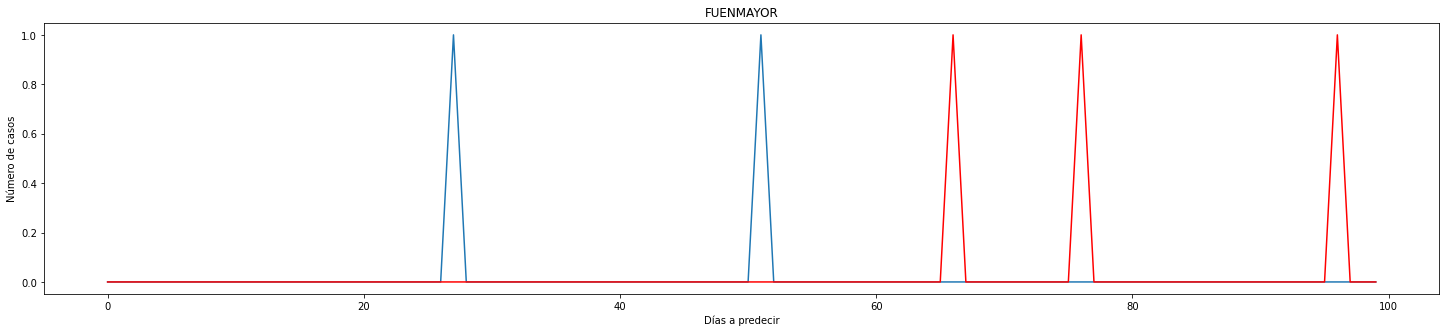

[2, 3, 0.22360679774997896]

In [208]:
AR_Test(df_zeros, "FUENMAYOR", 100, 600, True)

### BUGA

In [168]:
dfBuga = df[df.City == 'Buga']

In [172]:
neighborhoods = dfBuga['Neighborhood'].value_counts()
neighborhoods = neighborhoods.to_frame(name='Cases')
neighborhoods = neighborhoods[neighborhoods.Cases >= 100]

Test RMSE: 0.224 - Total predictions: 3 - Real cases: 2 - LAGS: 600 - Days to predict: 100


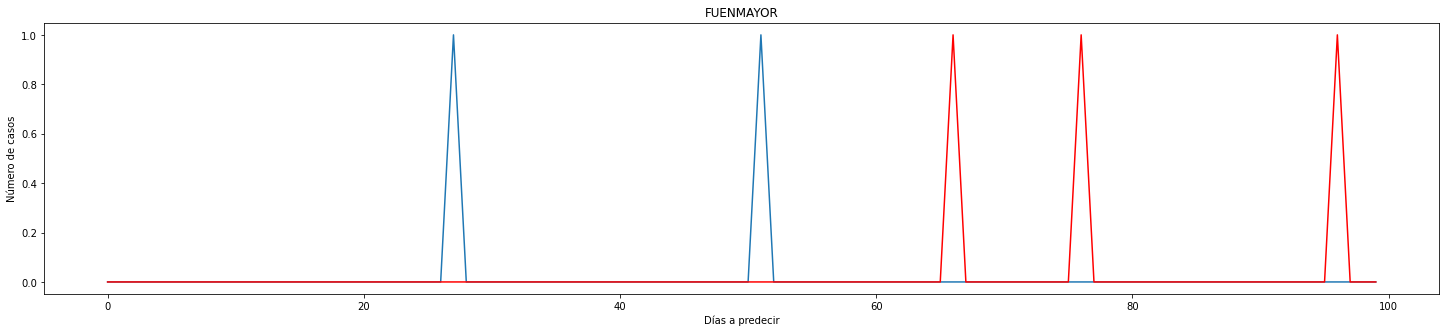

Test RMSE: 0.213 - Total predictions: 3 - Real cases: 2 - LAGS: 600 - Days to predict: 110


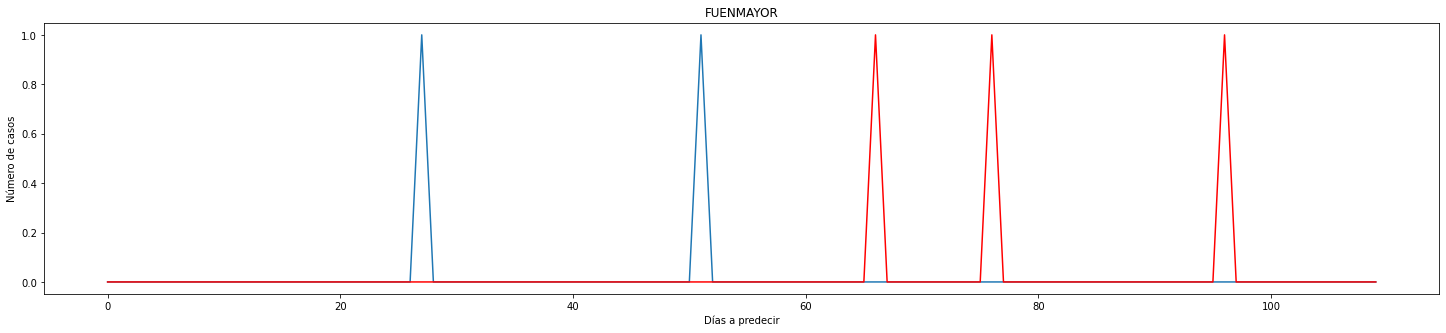

Test RMSE: 0.204 - Total predictions: 3 - Real cases: 2 - LAGS: 600 - Days to predict: 120


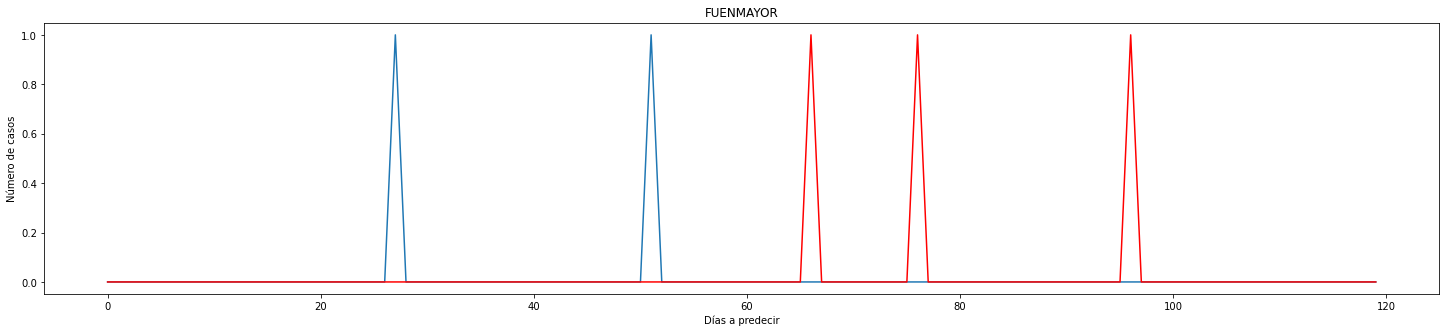

Test RMSE: 0.215 - Total predictions: 3 - Real cases: 3 - LAGS: 600 - Days to predict: 130


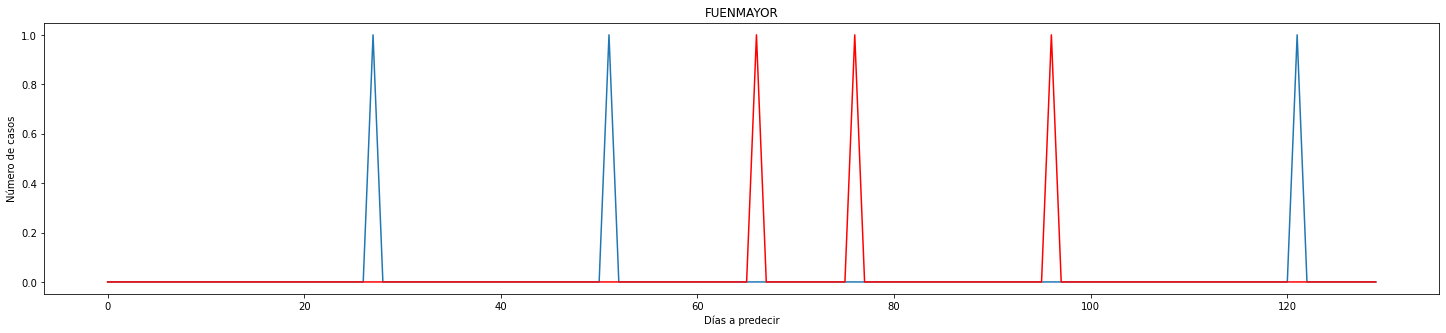

Test RMSE: 0.207 - Total predictions: 3 - Real cases: 3 - LAGS: 600 - Days to predict: 140


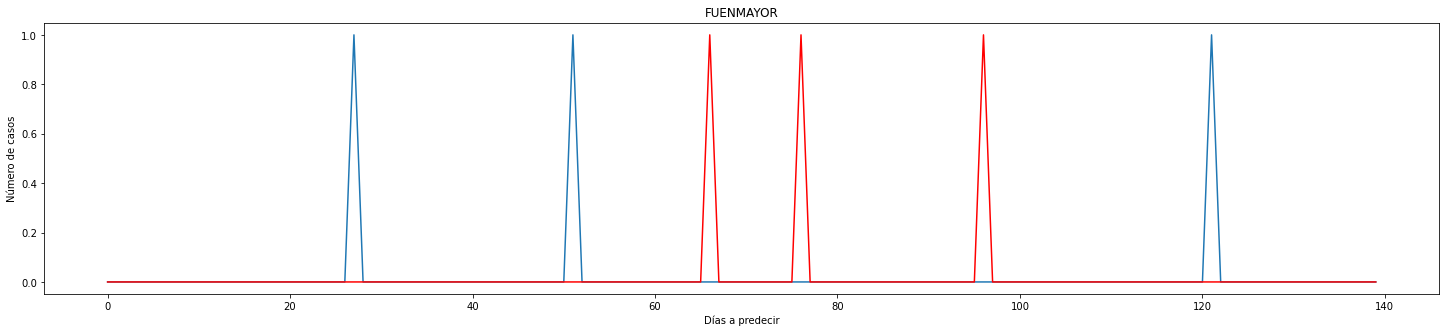

Test RMSE: 0.200 - Total predictions: 3 - Real cases: 3 - LAGS: 600 - Days to predict: 150


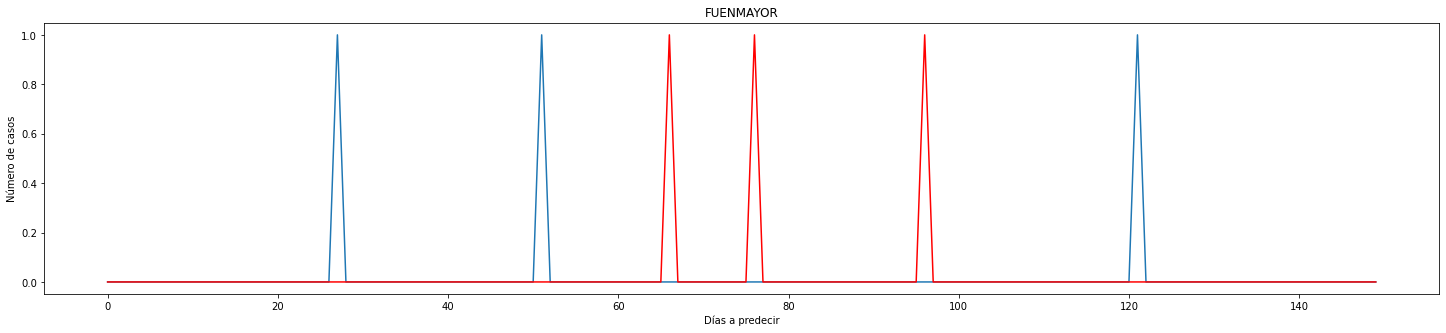

Test RMSE: 0.194 - Total predictions: 3 - Real cases: 3 - LAGS: 600 - Days to predict: 160


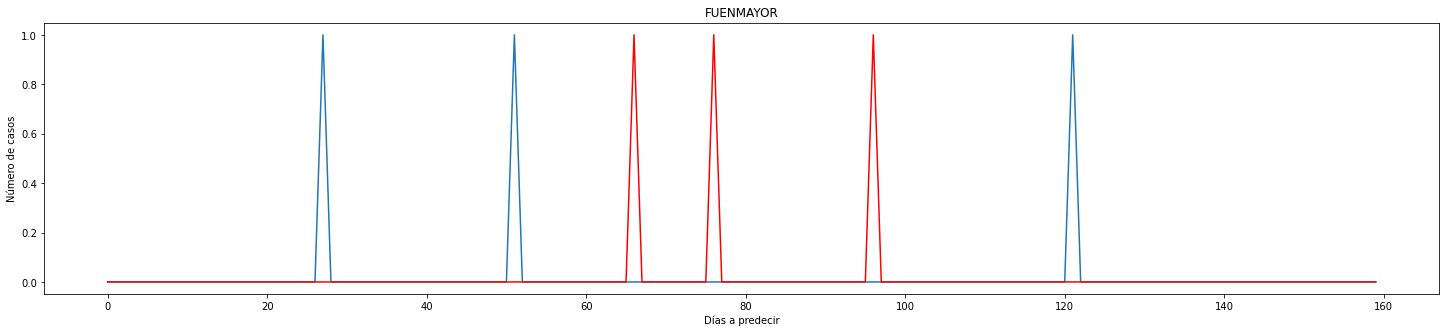

Test RMSE: 0.188 - Total predictions: 3 - Real cases: 3 - LAGS: 600 - Days to predict: 170


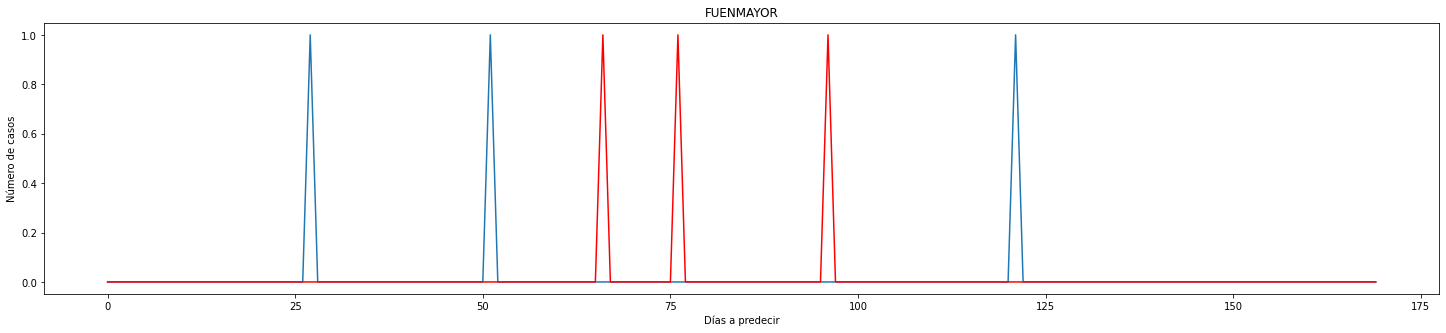

Test RMSE: 0.211 - Total predictions: 3 - Real cases: 5 - LAGS: 600 - Days to predict: 180


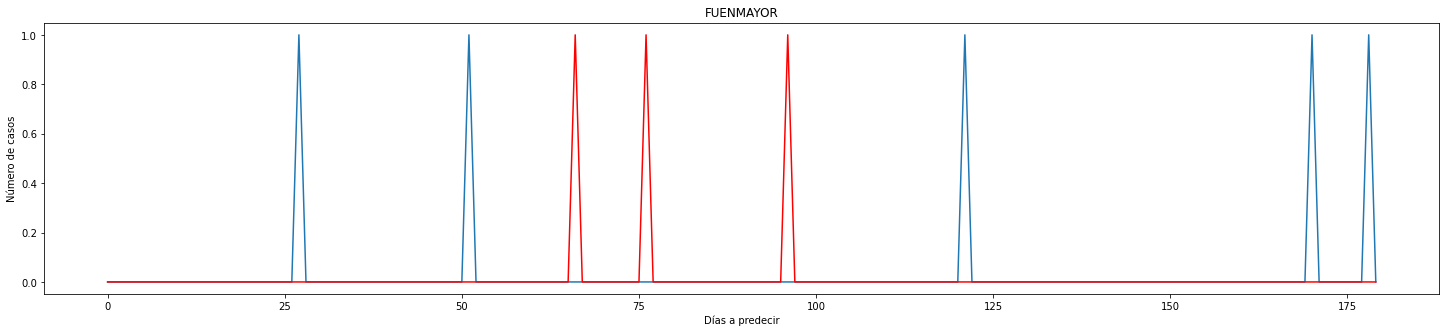

Test RMSE: 0.205 - Total predictions: 3 - Real cases: 5 - LAGS: 600 - Days to predict: 190


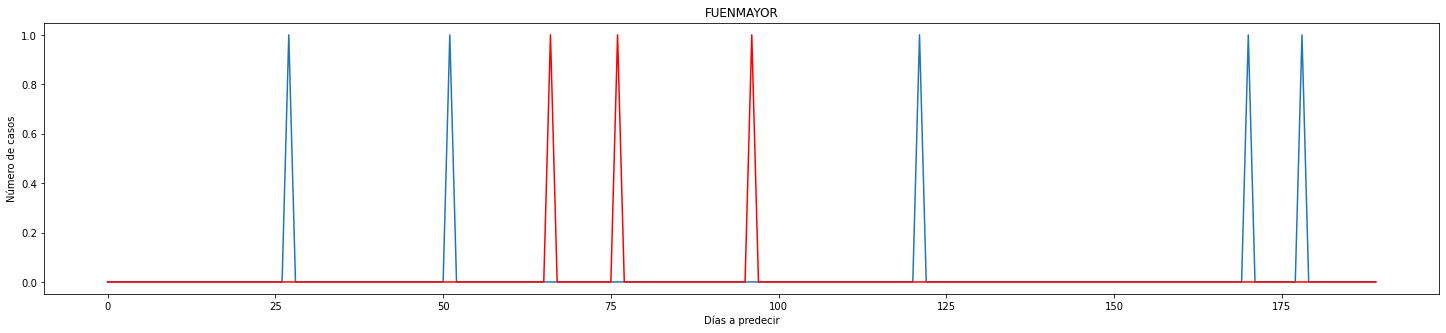

Test RMSE: 0.200 - Total predictions: 3 - Real cases: 5 - LAGS: 600 - Days to predict: 200


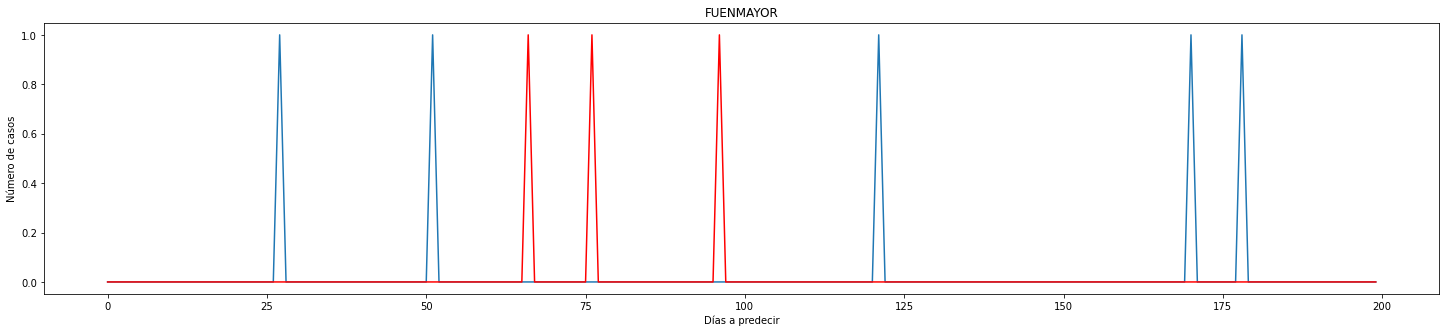

Test RMSE: 0.207 - Total predictions: 3 - Real cases: 6 - LAGS: 600 - Days to predict: 210


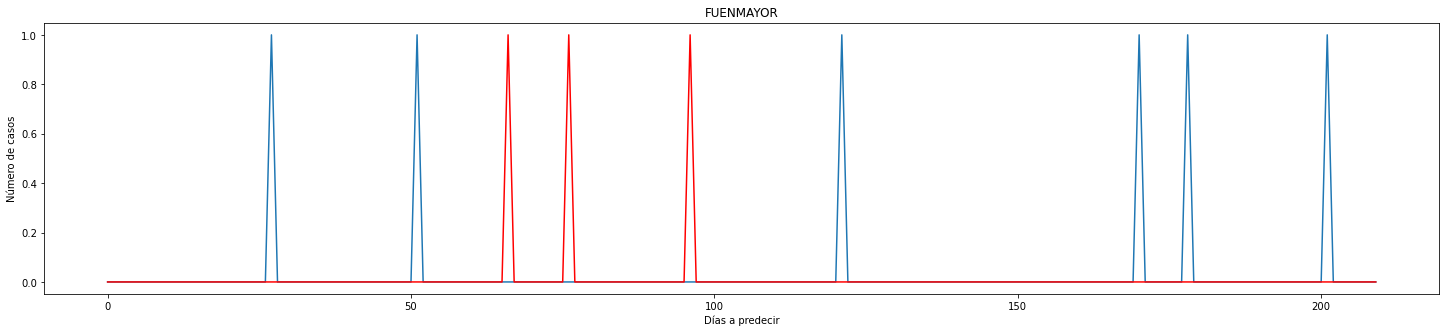

Test RMSE: 0.202 - Total predictions: 3 - Real cases: 6 - LAGS: 600 - Days to predict: 220


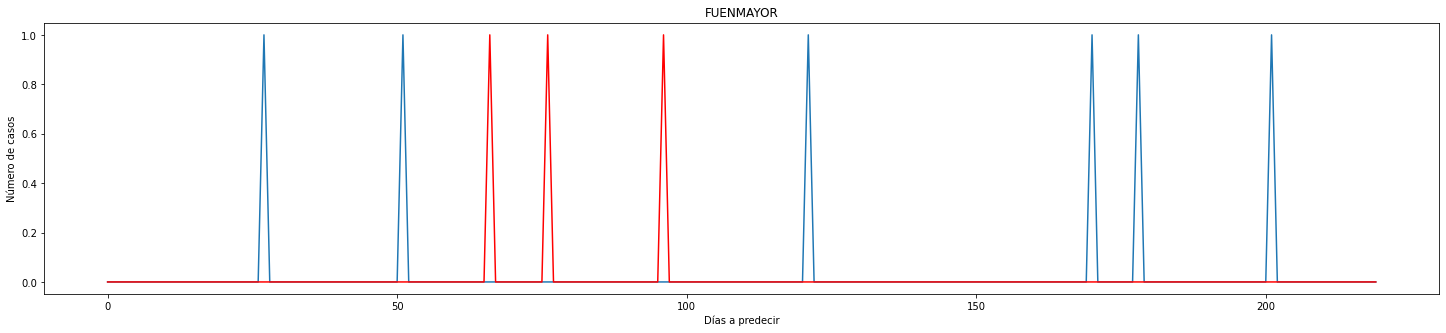

Test RMSE: 0.209 - Total predictions: 3 - Real cases: 7 - LAGS: 600 - Days to predict: 230


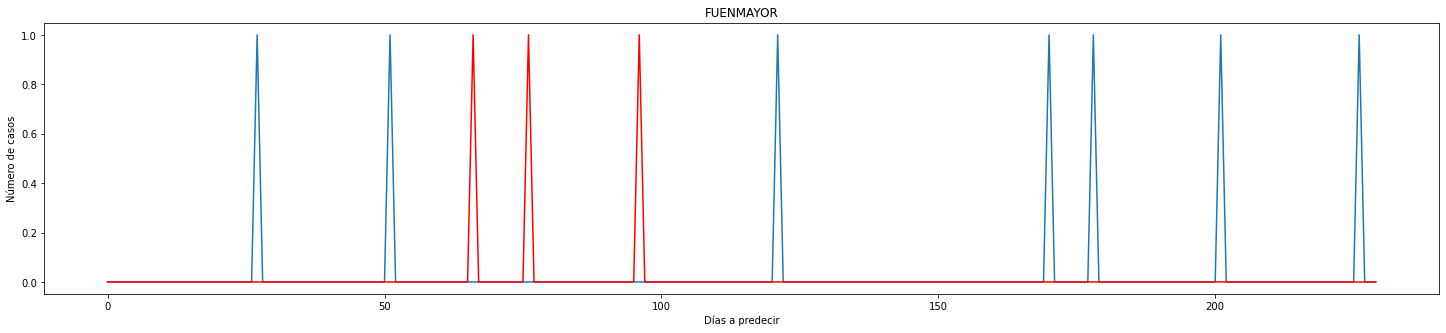

Test RMSE: 0.204 - Total predictions: 3 - Real cases: 7 - LAGS: 600 - Days to predict: 240


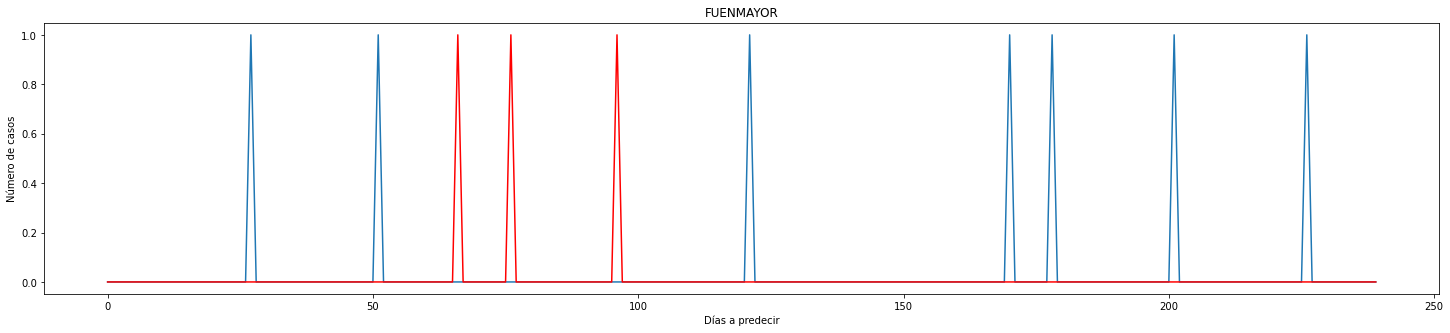

Test RMSE: 0.200 - Total predictions: 3 - Real cases: 7 - LAGS: 600 - Days to predict: 250


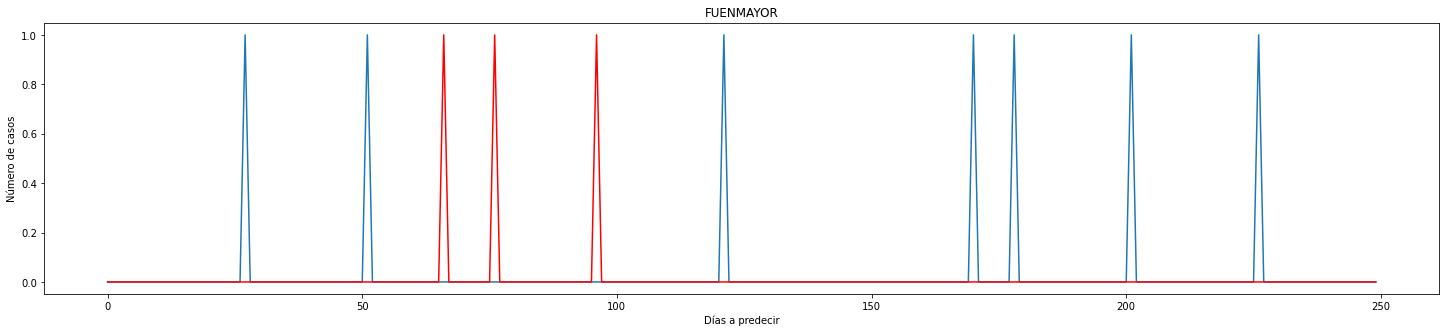

Test RMSE: 0.196 - Total predictions: 3 - Real cases: 7 - LAGS: 600 - Days to predict: 260


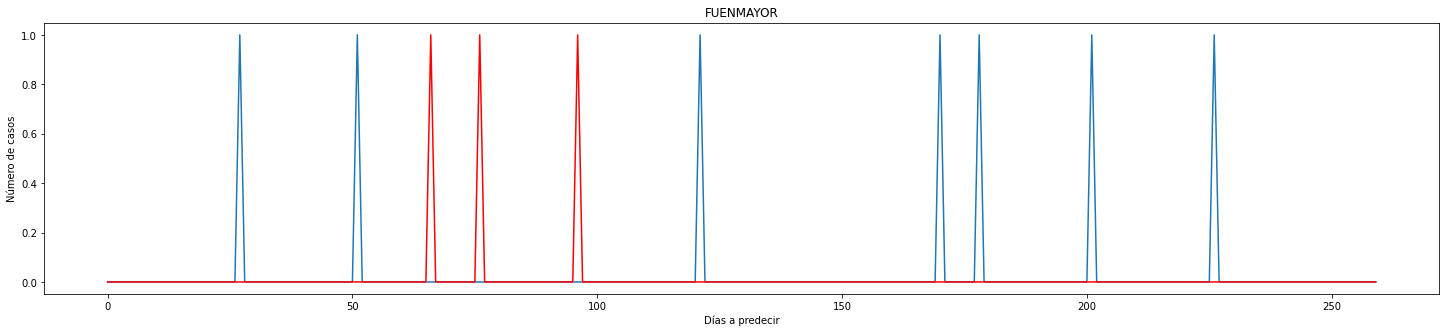

Test RMSE: 0.202 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 270


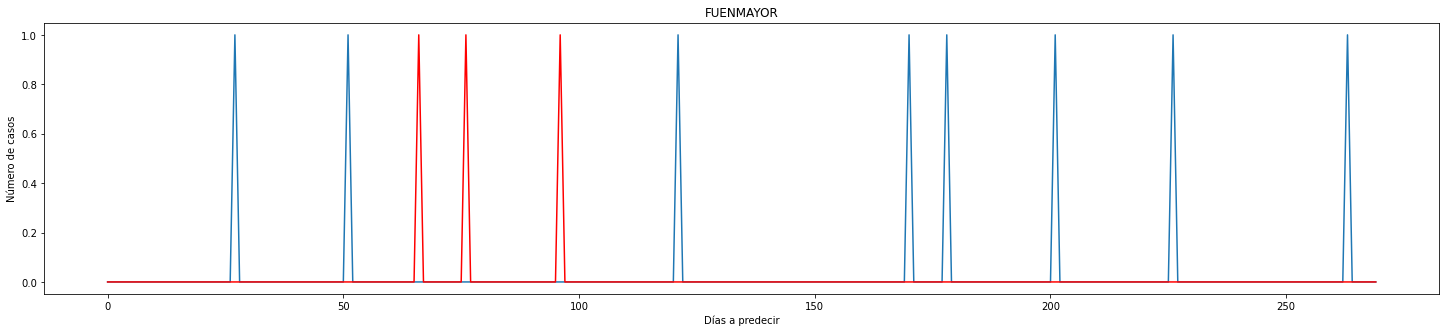

Test RMSE: 0.198 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 280


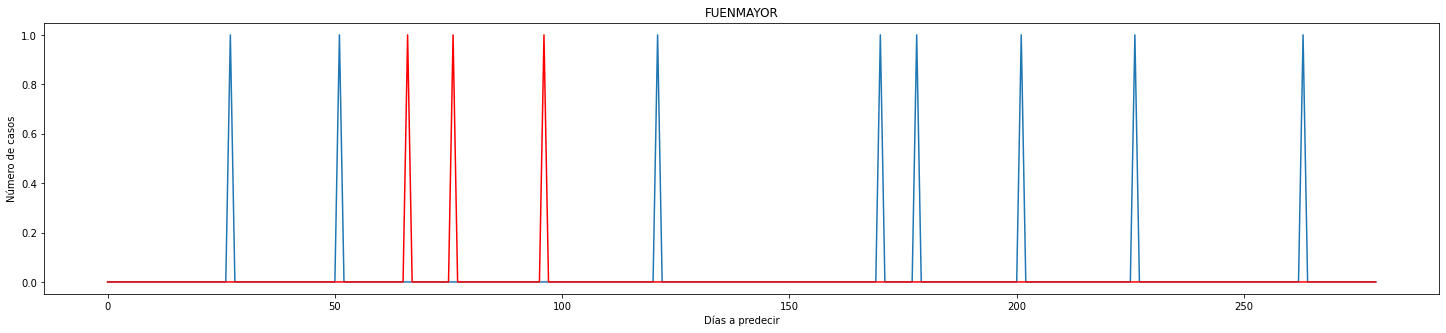

Test RMSE: 0.195 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 290


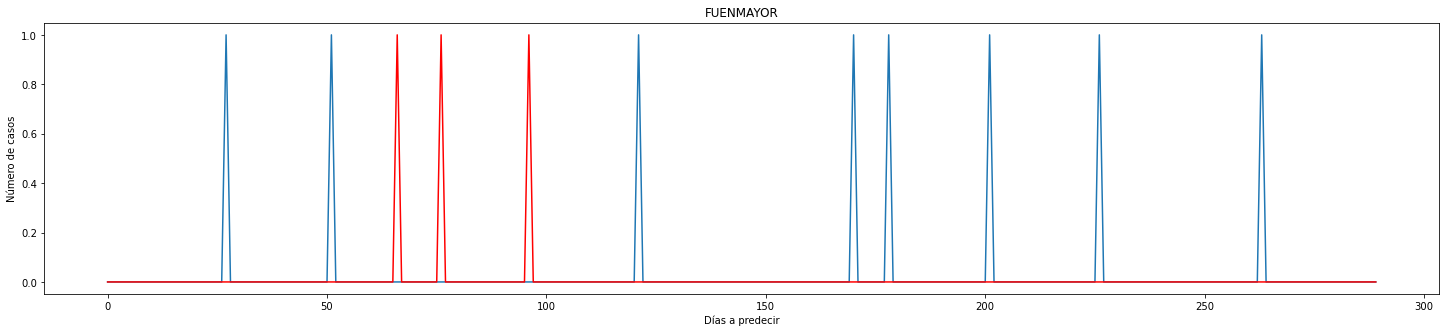

Test RMSE: 0.191 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 300


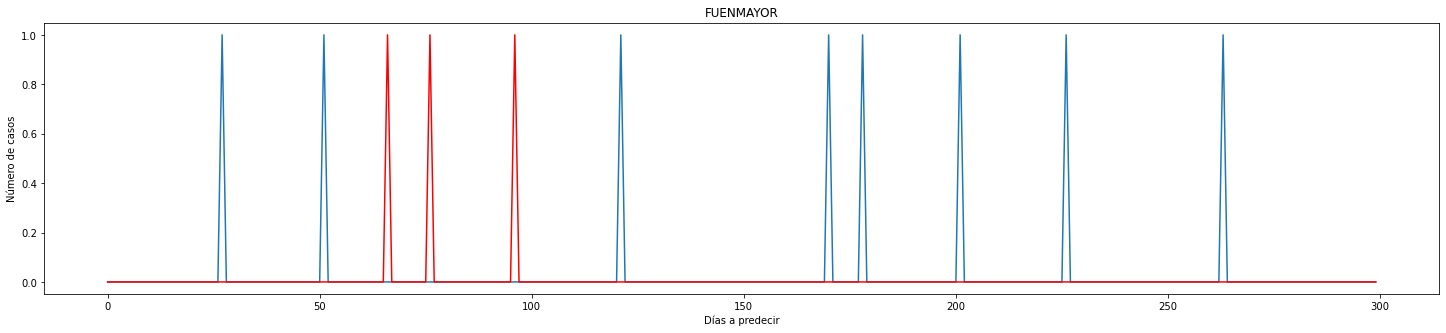

Test RMSE: 0.188 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 310


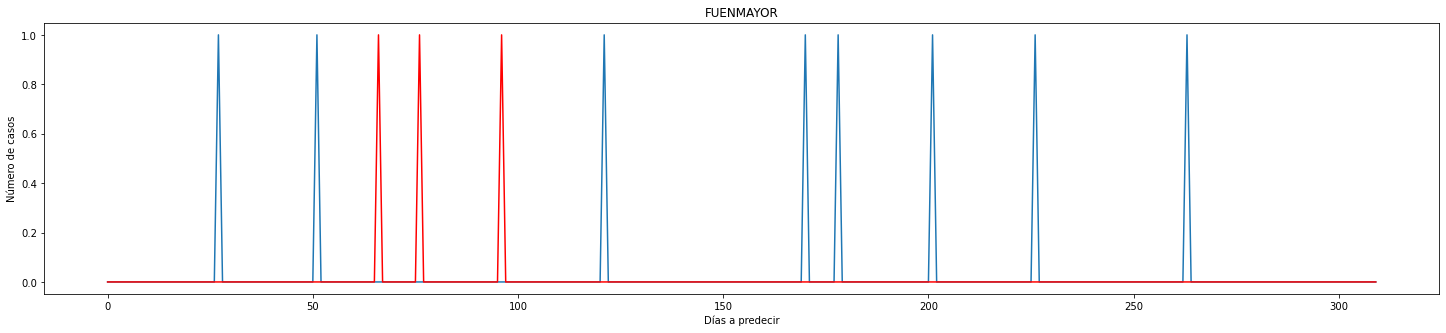

Test RMSE: 0.185 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 320


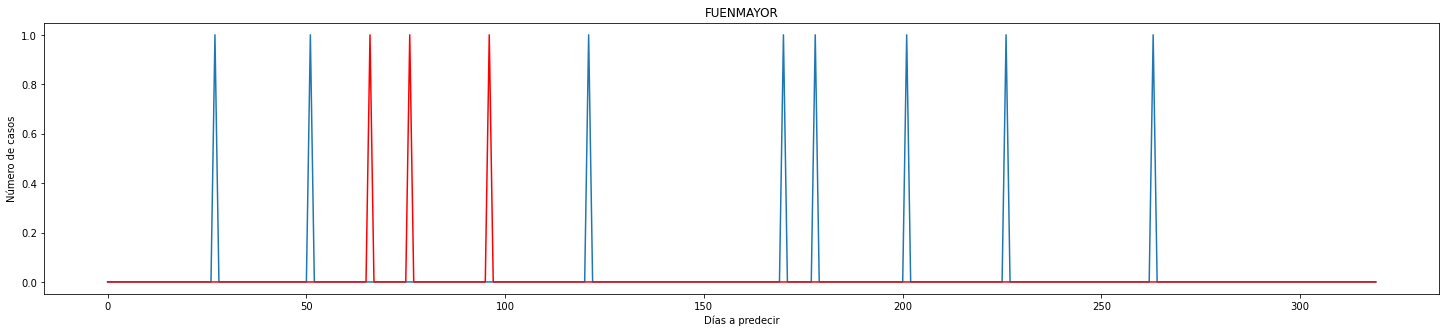

Test RMSE: 0.183 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 330


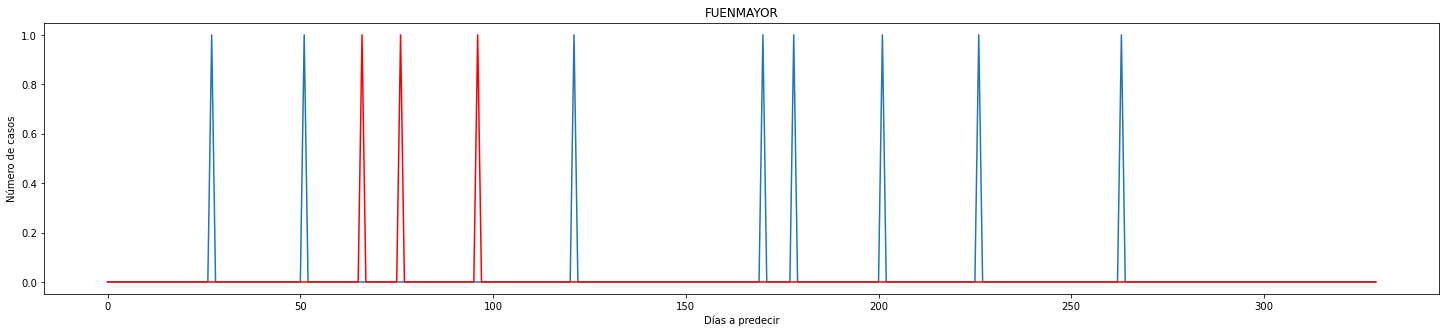

Test RMSE: 0.180 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 340


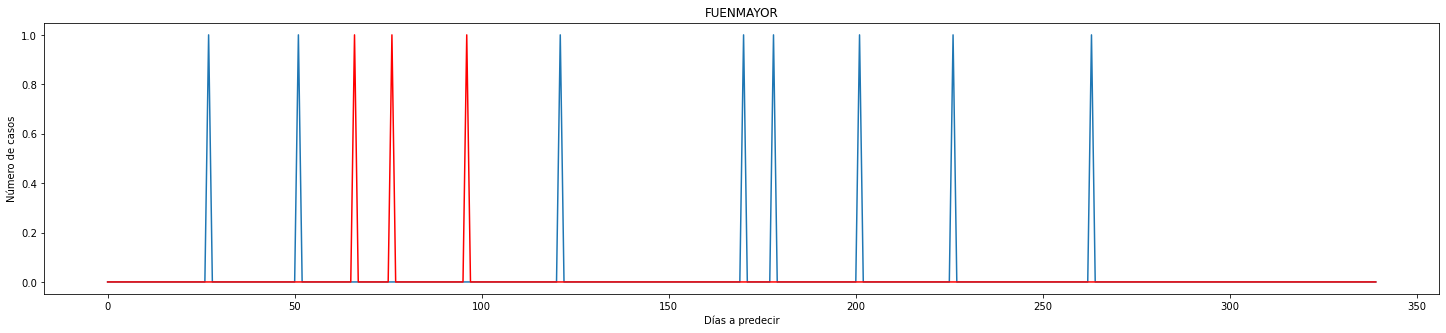

Test RMSE: 0.177 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 350


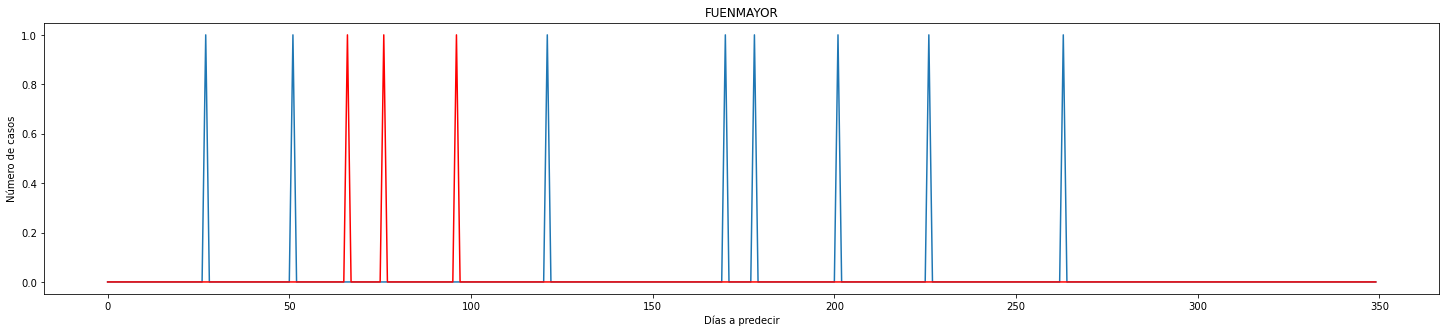

Test RMSE: 0.175 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 360


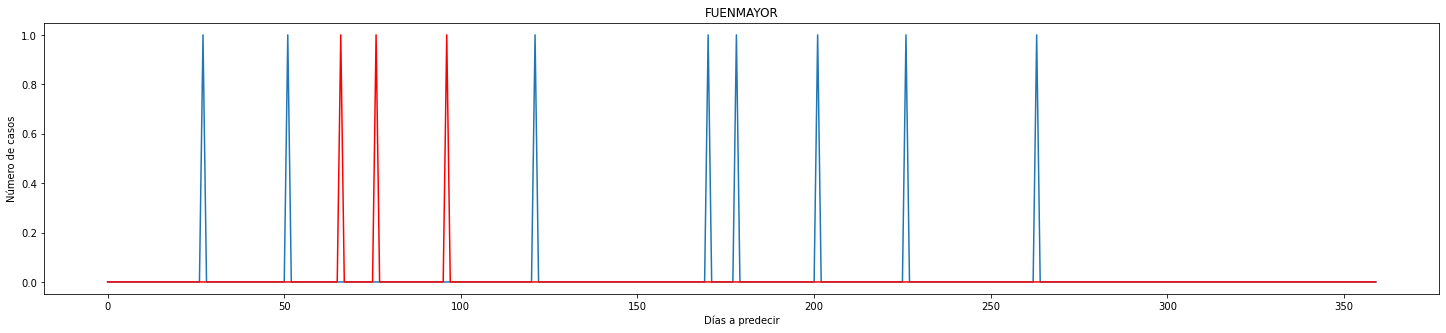

Test RMSE: 0.172 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 370


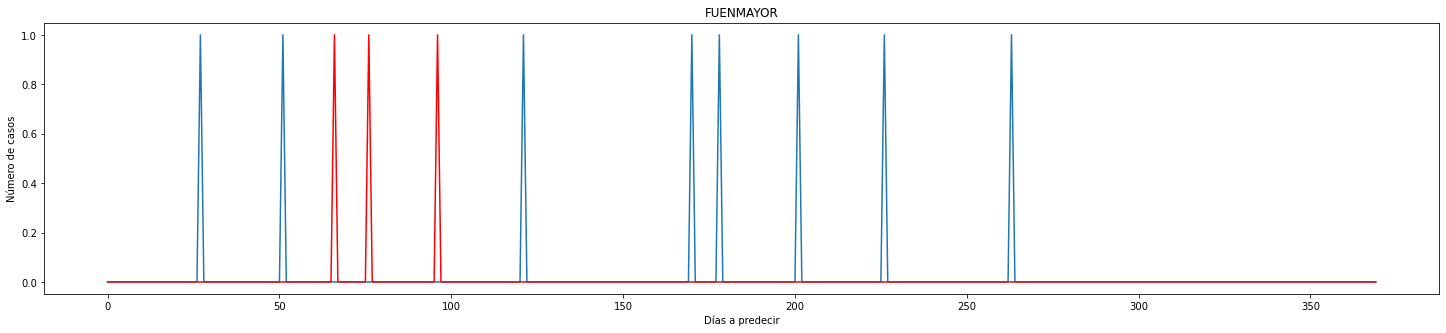

Test RMSE: 0.170 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 380


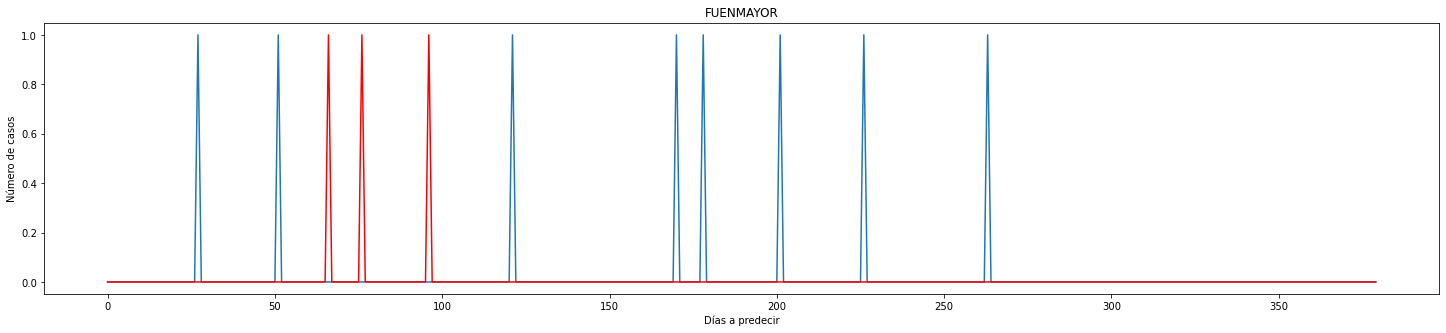

Test RMSE: 0.168 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 390


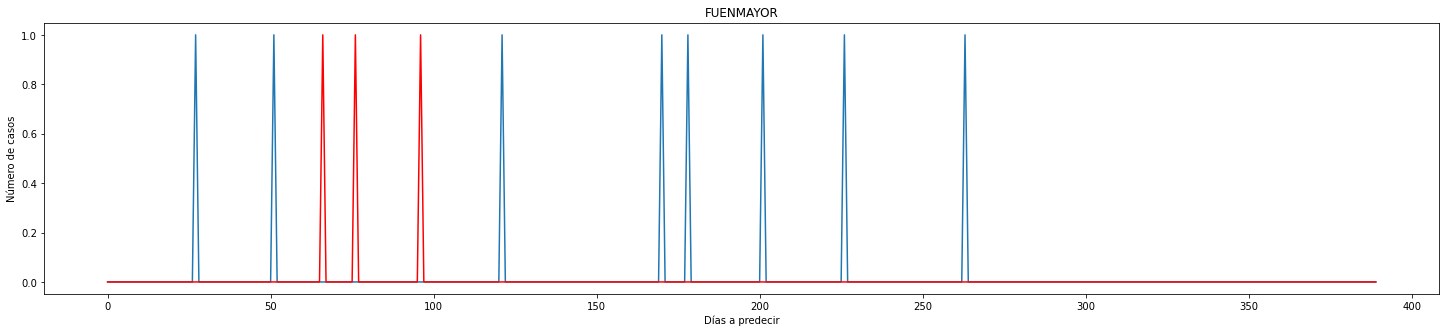

Test RMSE: 0.166 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 400


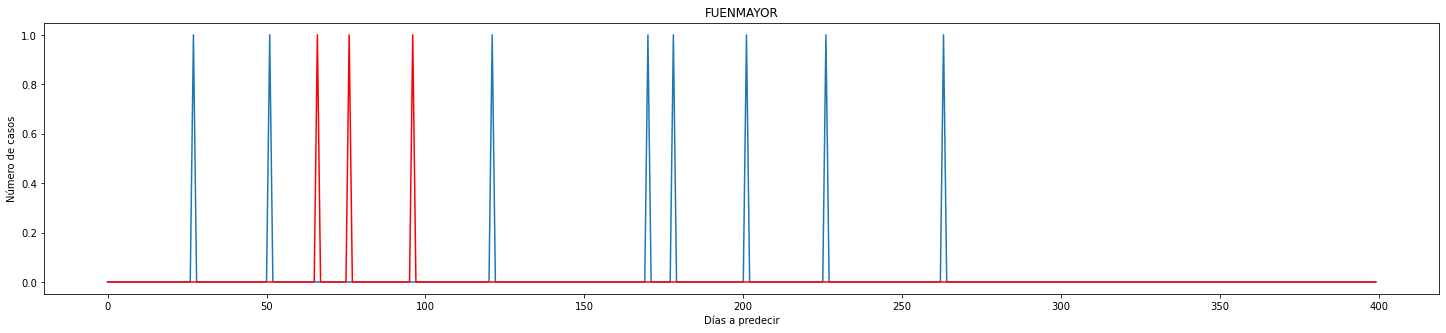

Test RMSE: 0.164 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 410


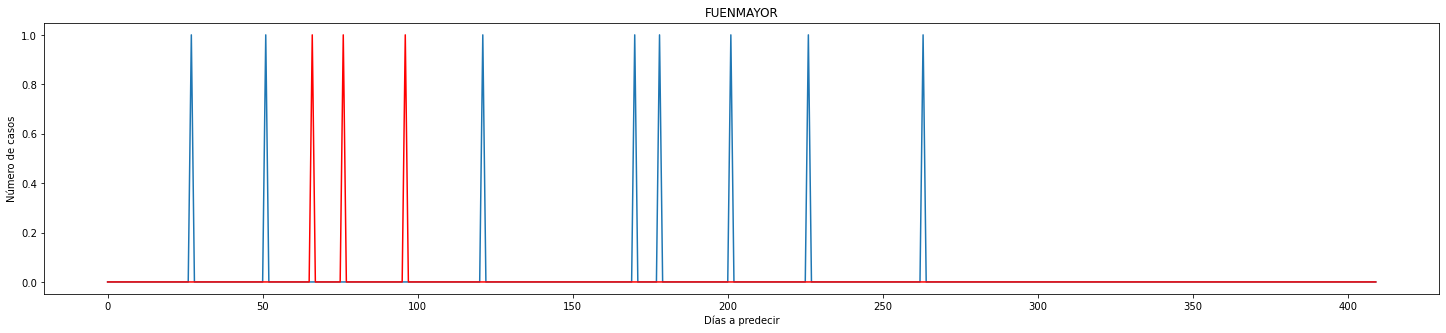

Test RMSE: 0.162 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 420


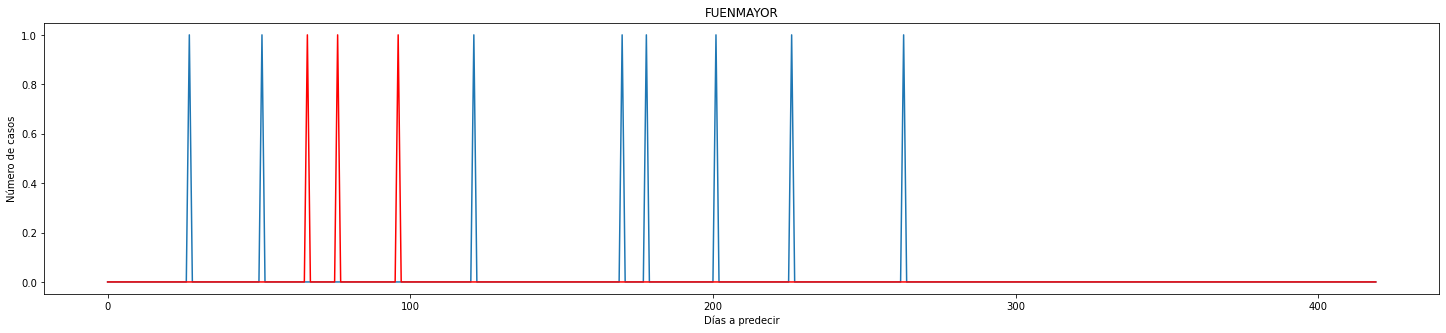

Test RMSE: 0.160 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 430


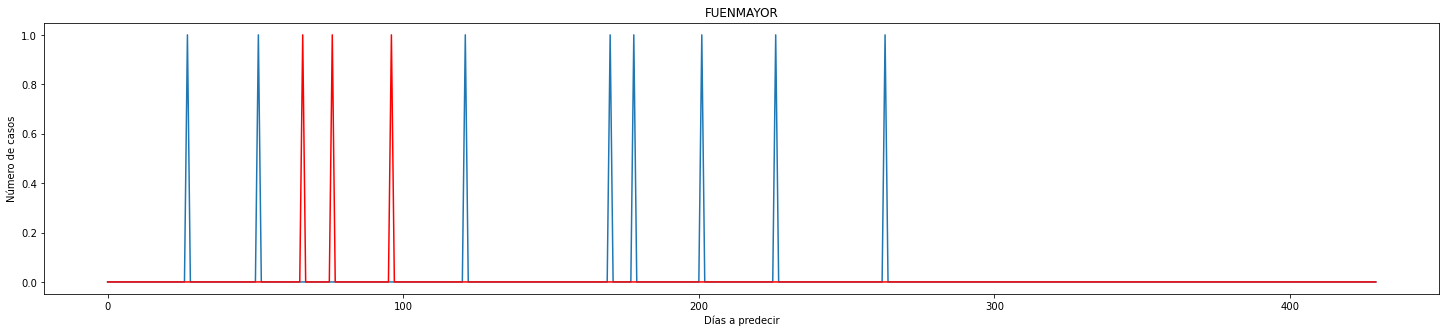

Test RMSE: 0.158 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 440


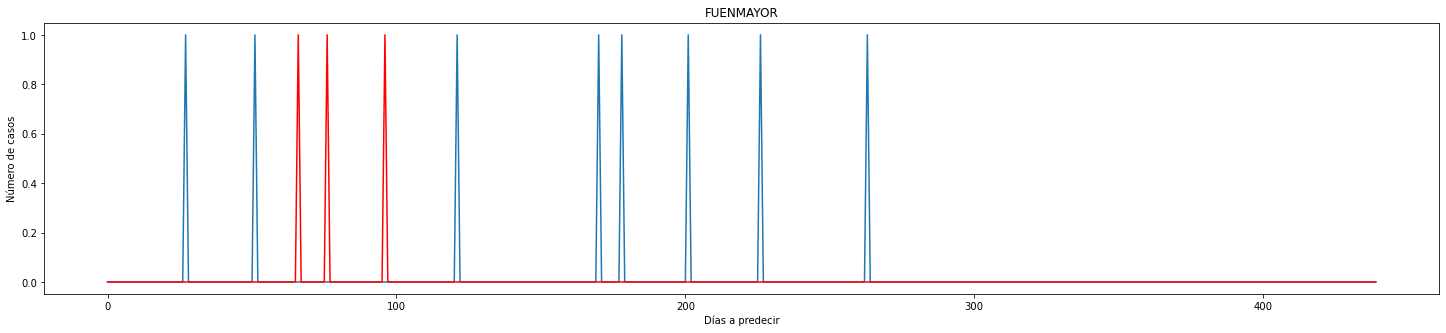

Test RMSE: 0.156 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 450


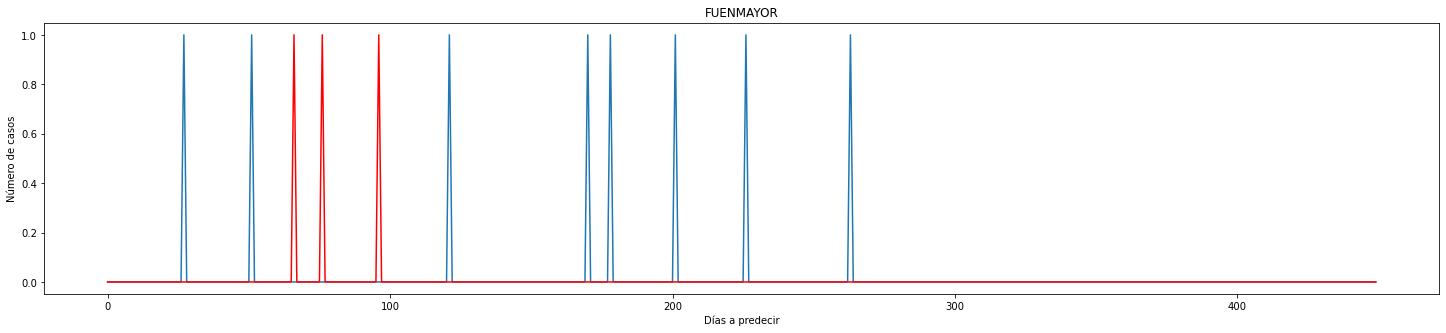

Test RMSE: 0.155 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 460


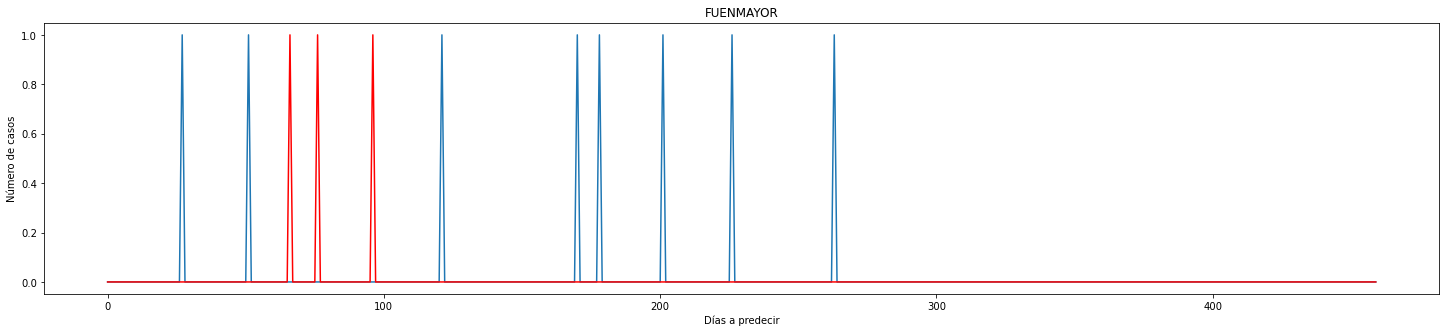

Test RMSE: 0.153 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 470


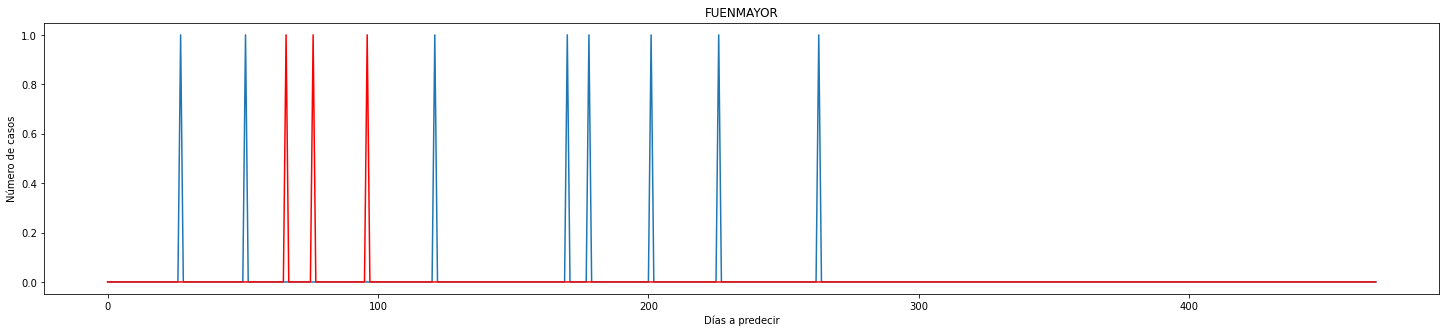

Test RMSE: 0.151 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 480


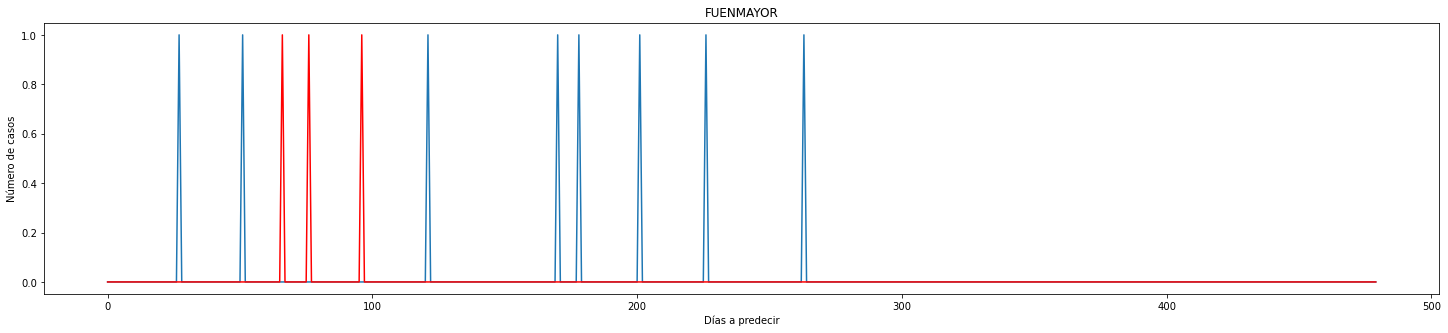

Test RMSE: 0.150 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 490


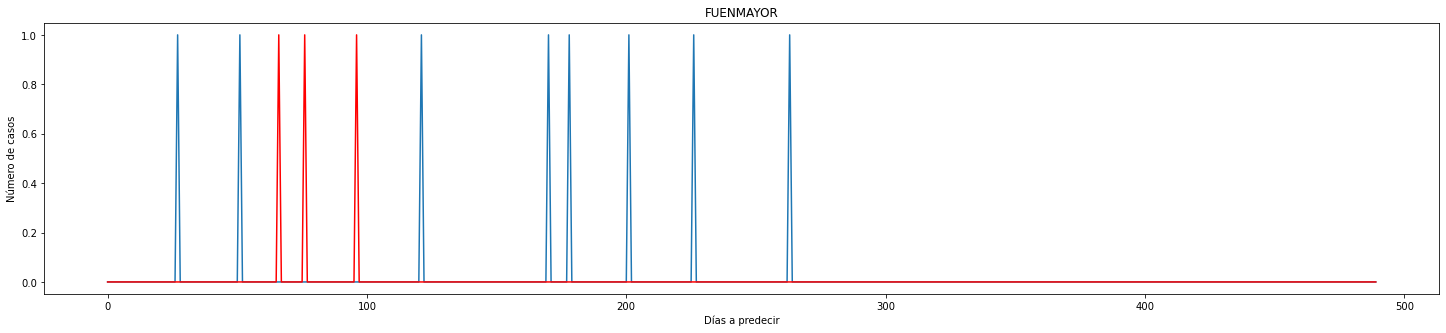

Test RMSE: 0.148 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 500


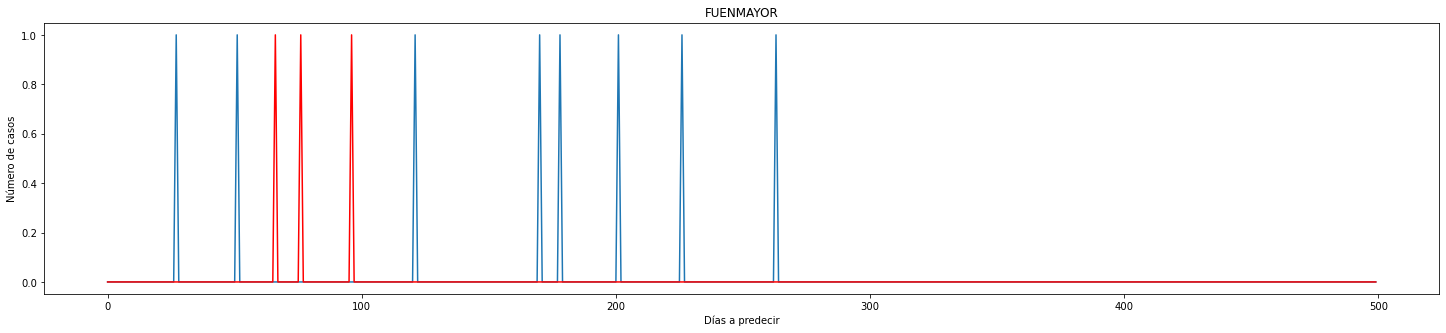

Test RMSE: 0.147 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 510


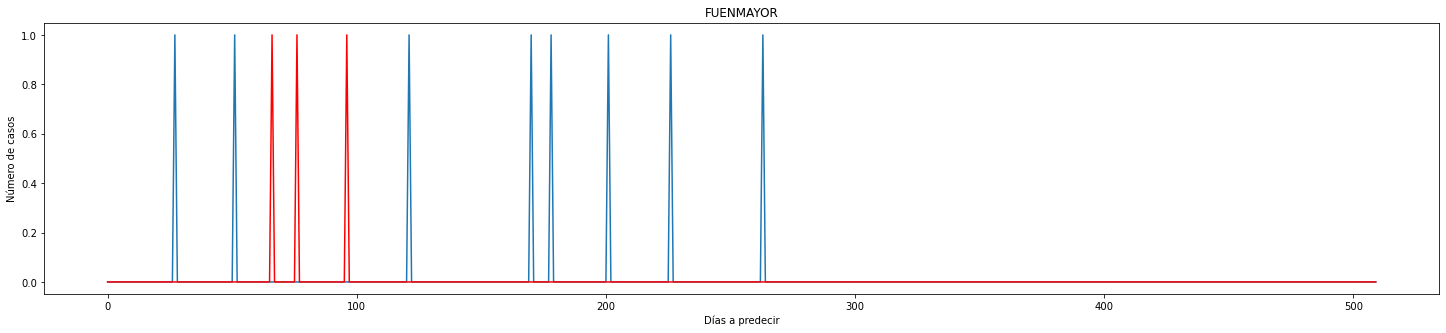

Test RMSE: 0.145 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 520


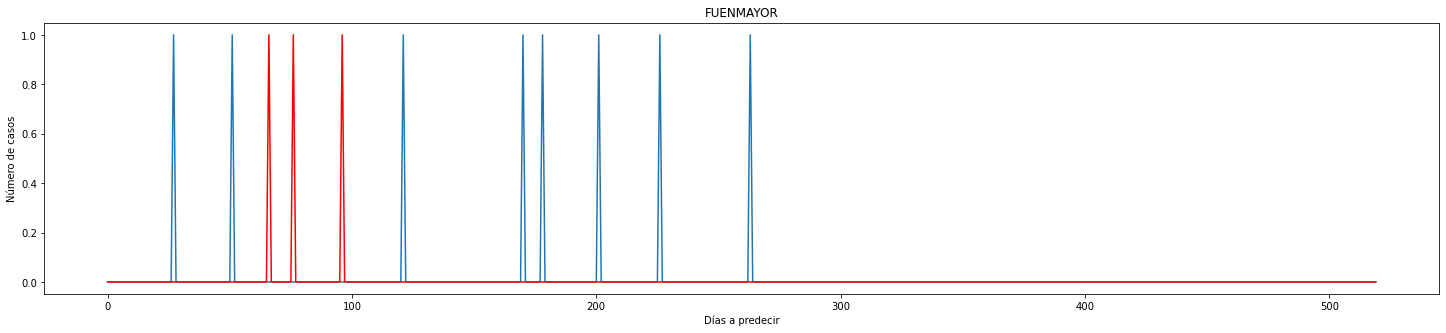

Test RMSE: 0.144 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 530


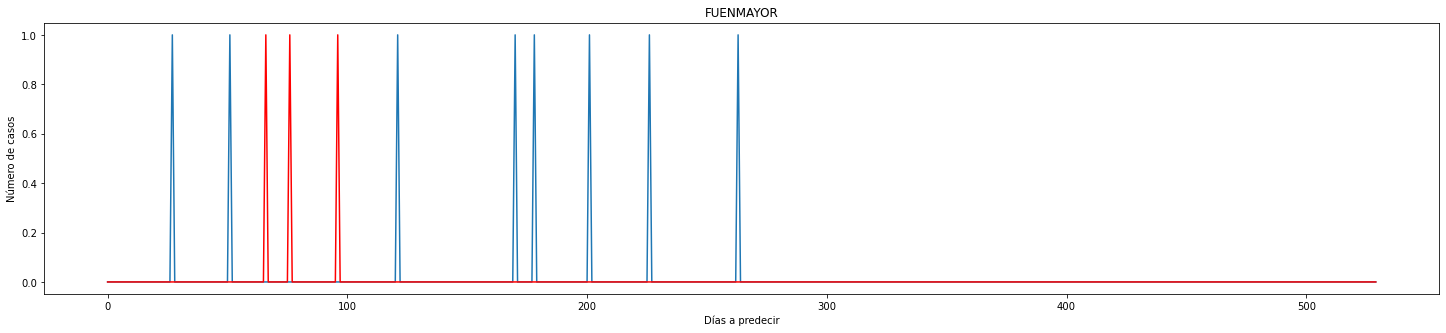

Test RMSE: 0.143 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 540


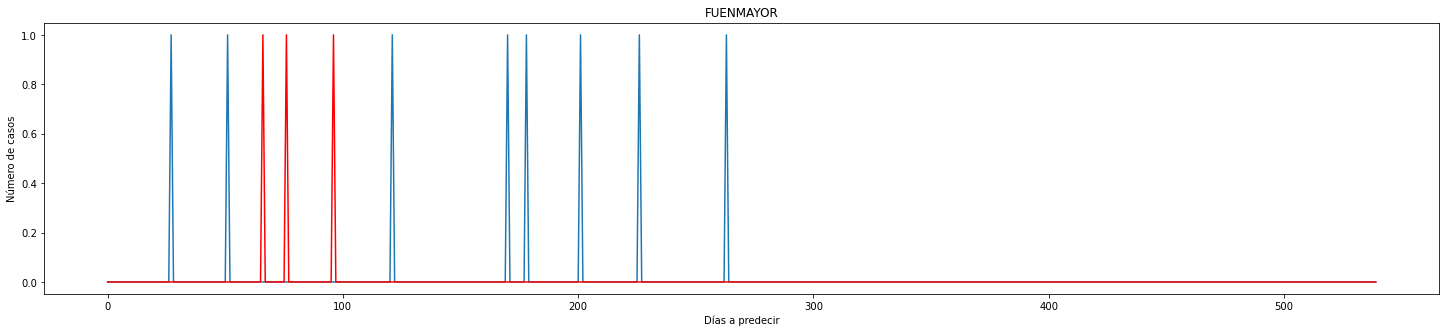

Test RMSE: 0.141 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 550


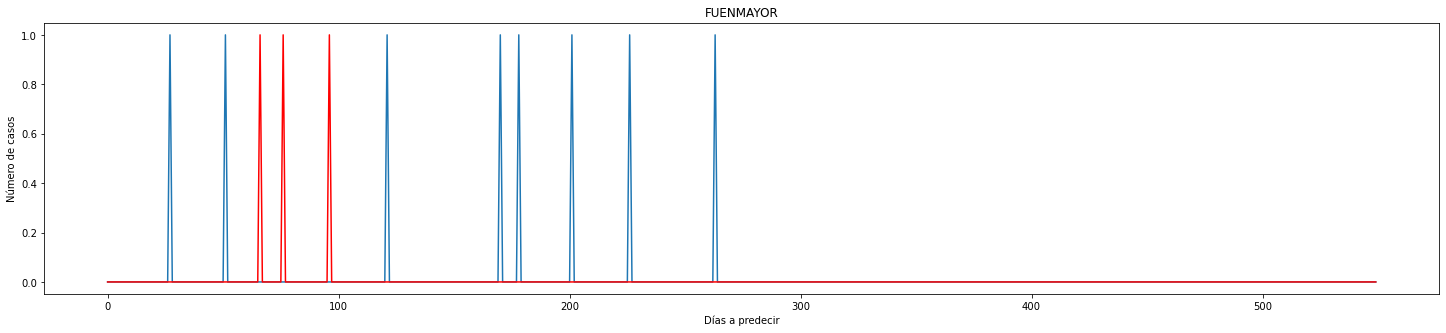

Test RMSE: 0.140 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 560


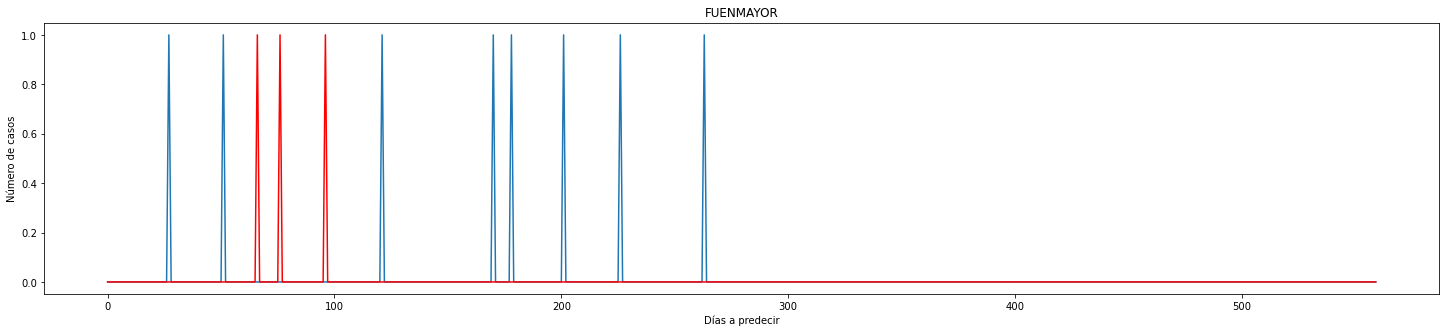

Test RMSE: 0.139 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 570


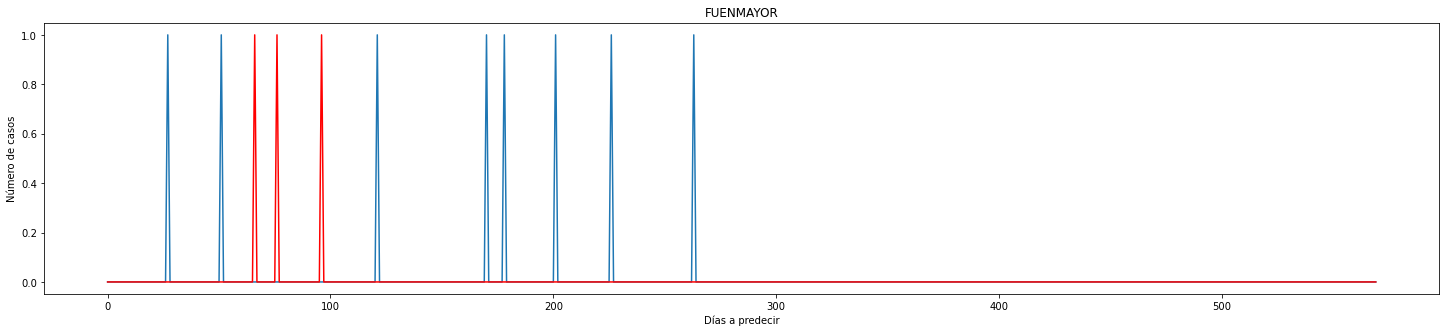

Test RMSE: 0.138 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 580


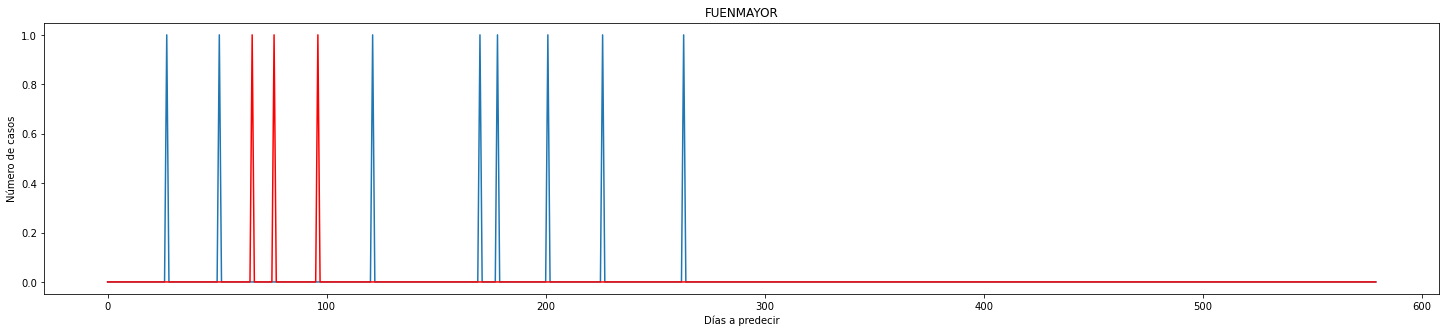

Test RMSE: 0.137 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 590


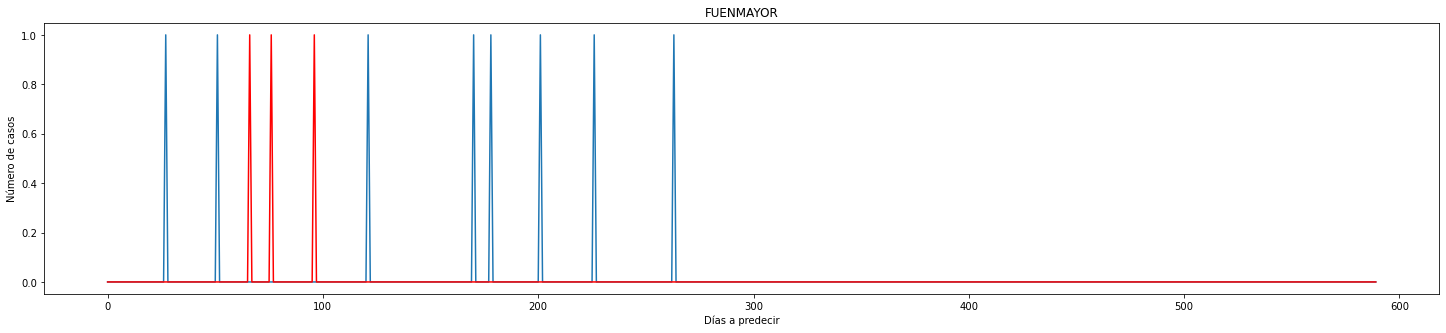

Test RMSE: 0.135 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 600


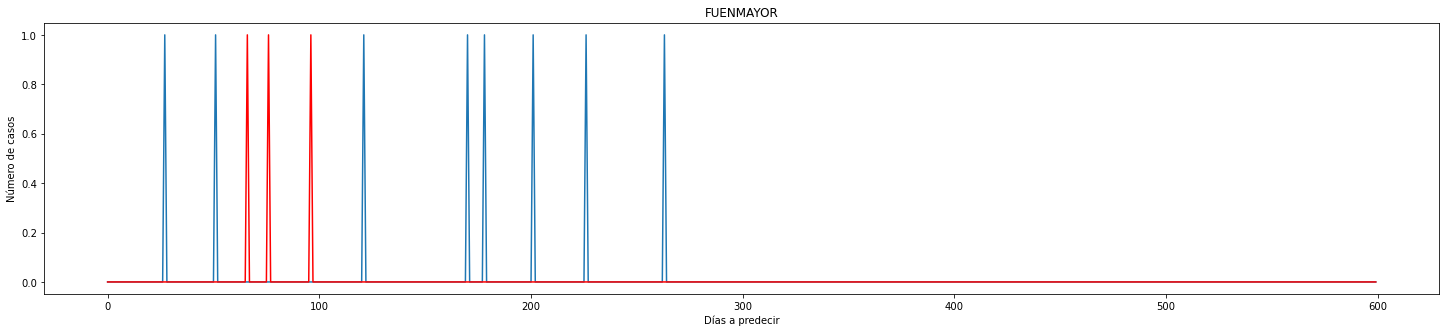

Test RMSE: 0.134 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 610


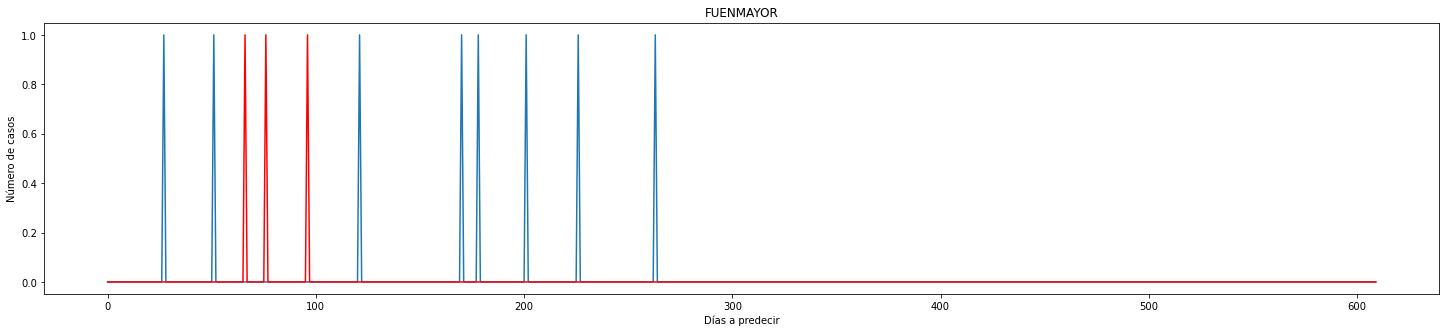

Test RMSE: 0.133 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 620


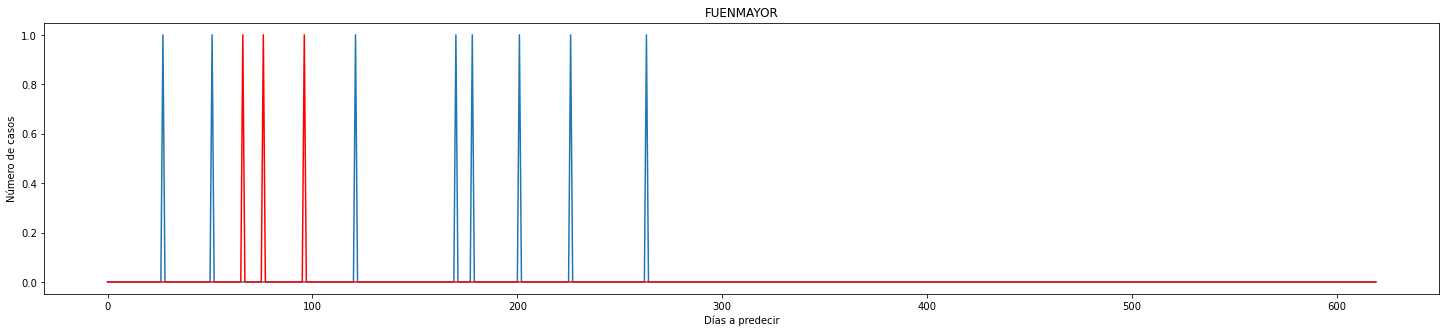

Test RMSE: 0.132 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 630


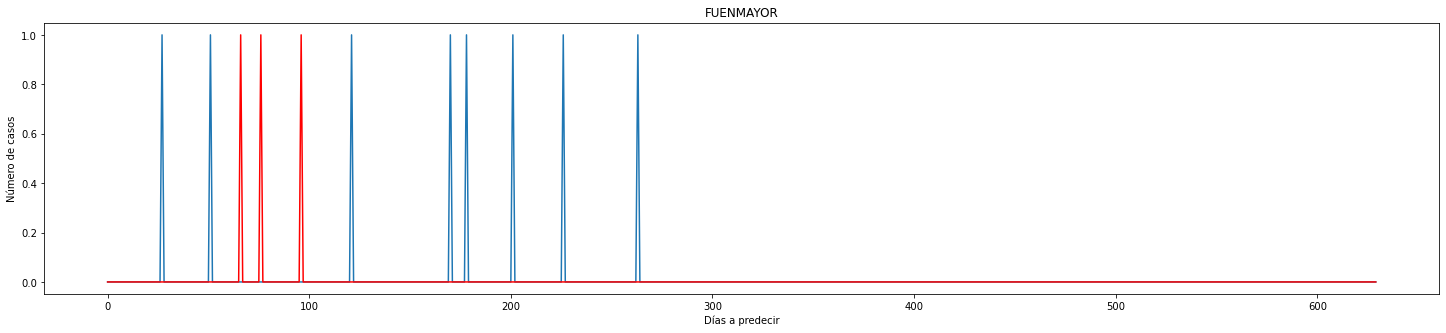

Test RMSE: 0.131 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 640


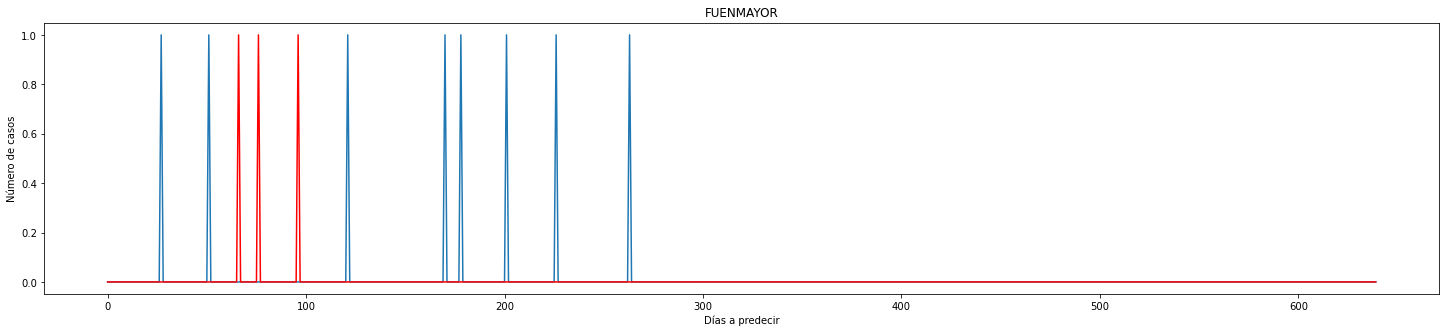

Test RMSE: 0.130 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 650


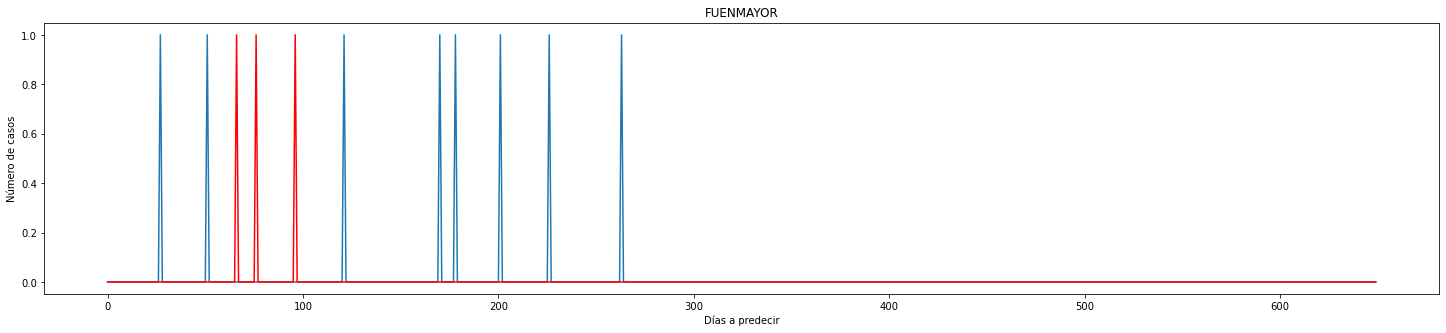

Test RMSE: 0.129 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 660


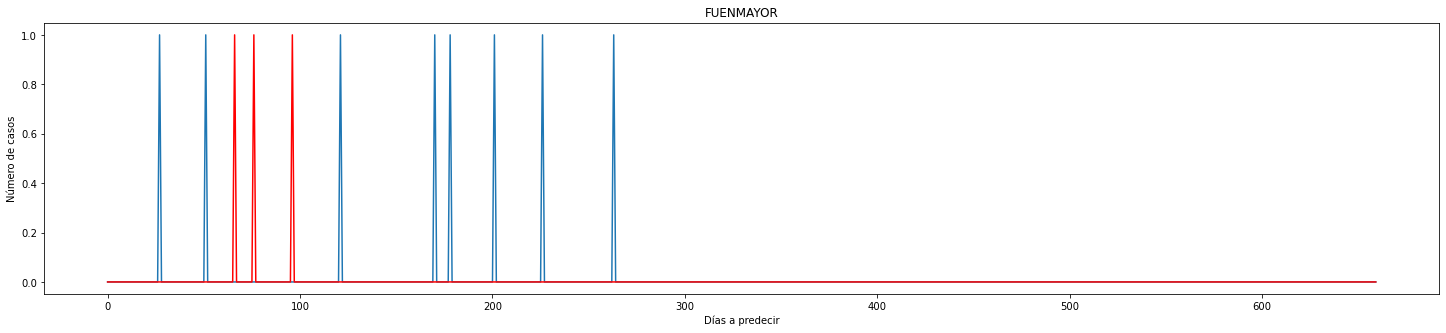

Test RMSE: 0.128 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 670


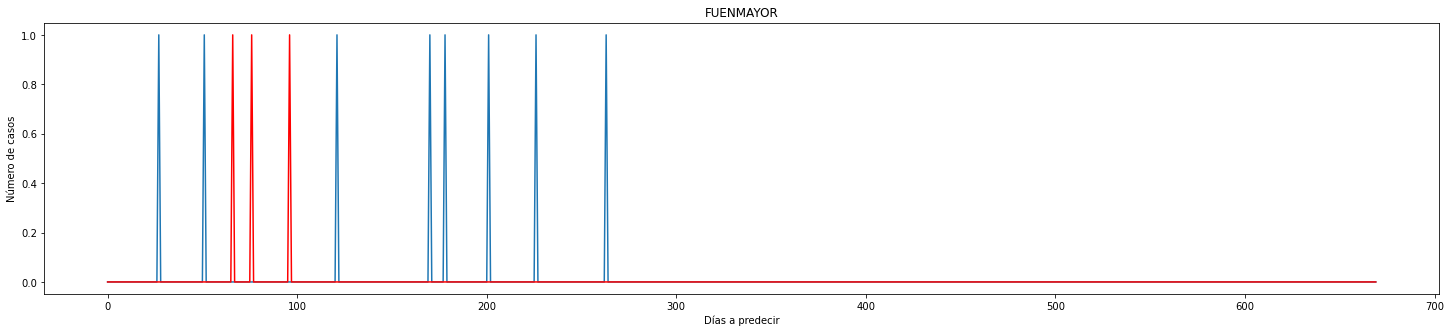

Test RMSE: 0.127 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 680


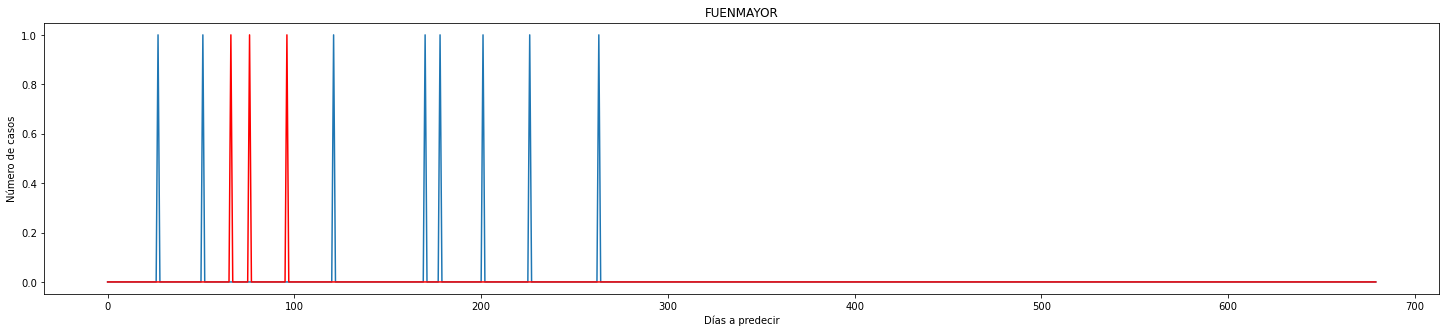

Test RMSE: 0.126 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 690


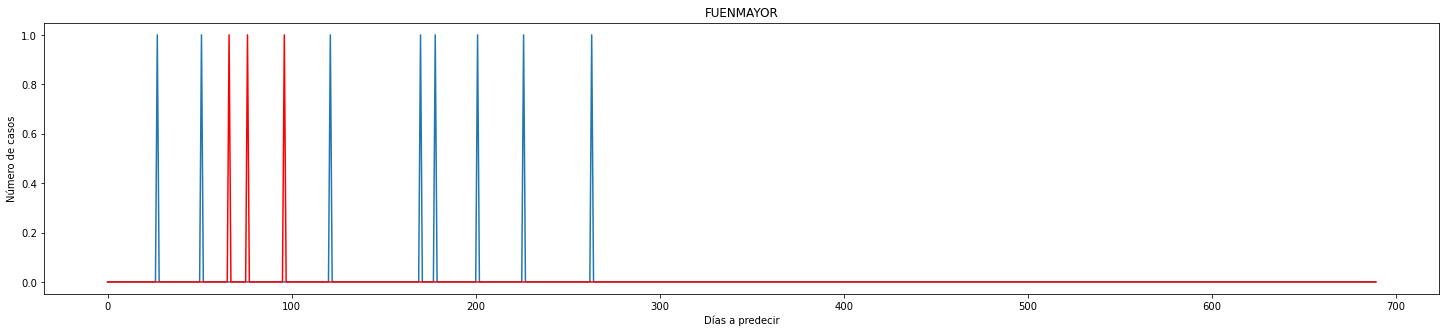

Test RMSE: 0.125 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 700


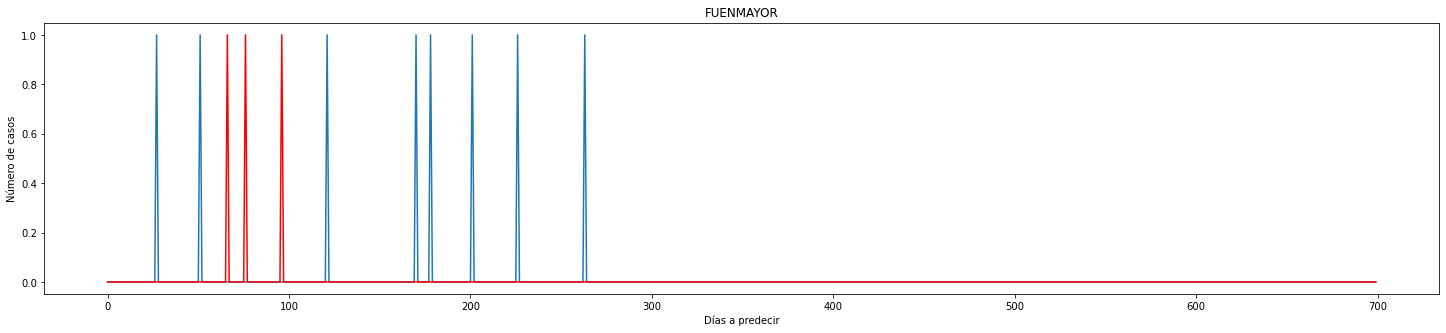

Test RMSE: 0.124 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 710


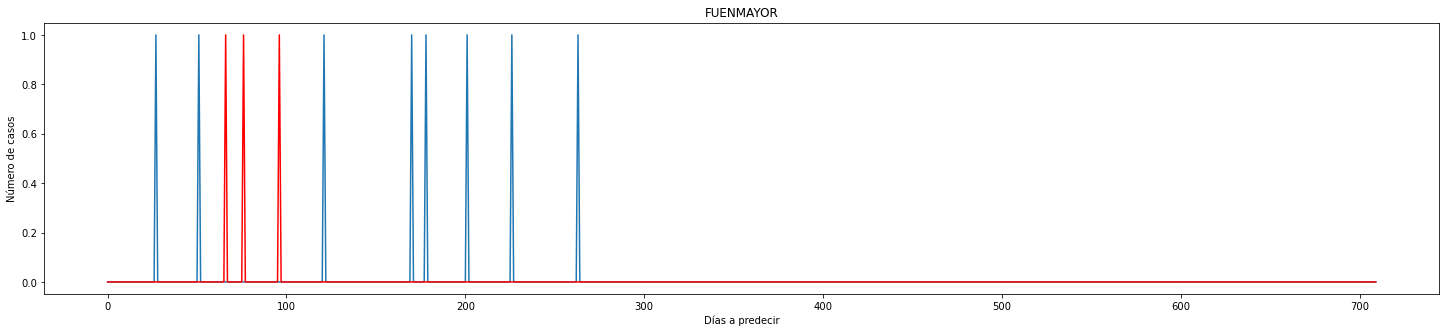

Test RMSE: 0.124 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 720


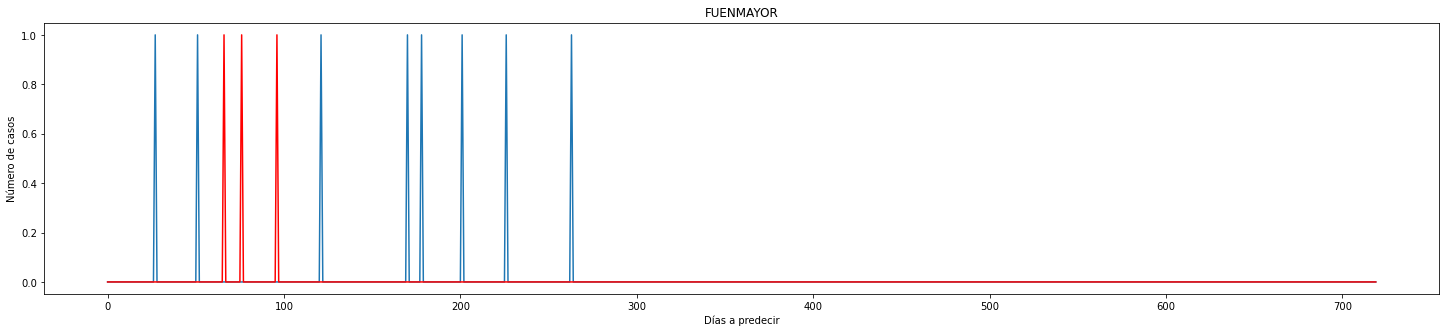

Test RMSE: 0.123 - Total predictions: 3 - Real cases: 8 - LAGS: 600 - Days to predict: 730


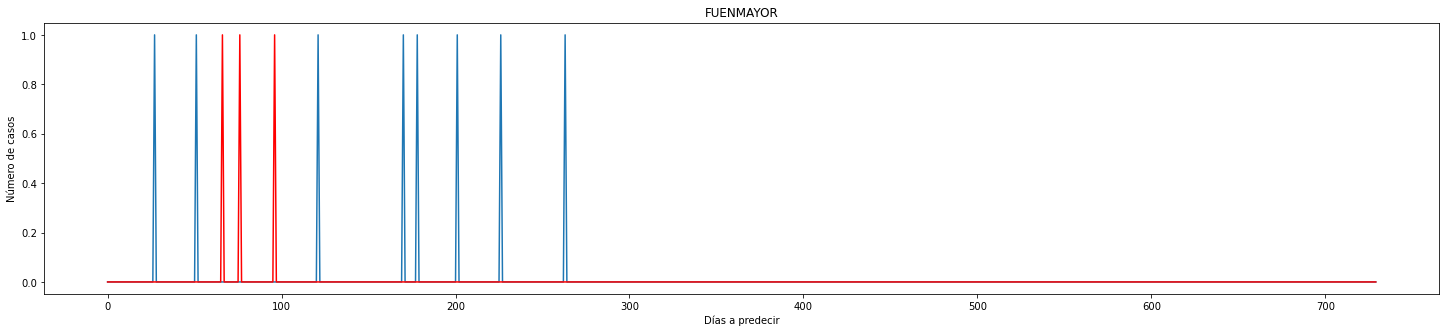

Test RMSE: 0.127 - Total predictions: 3 - Real cases: 9 - LAGS: 600 - Days to predict: 740


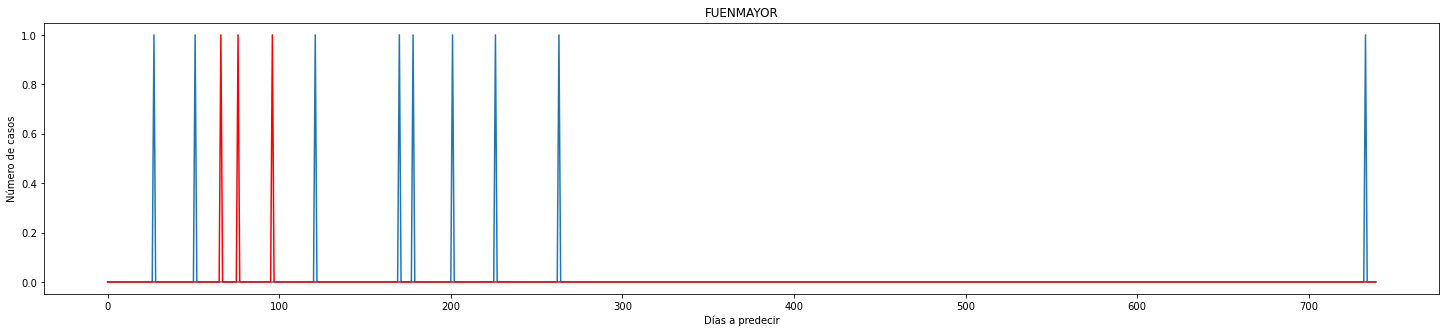

Test RMSE: 0.132 - Total predictions: 3 - Real cases: 10 - LAGS: 600 - Days to predict: 750


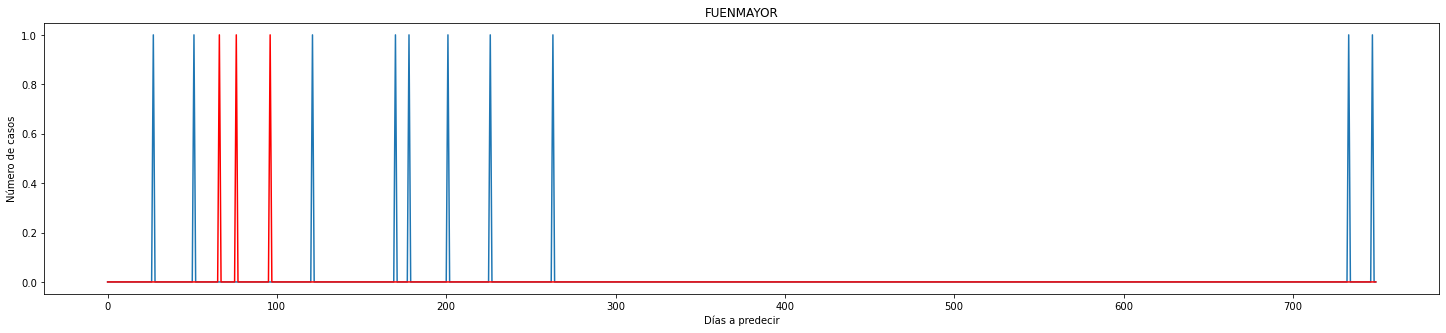

Test RMSE: 0.131 - Total predictions: 3 - Real cases: 10 - LAGS: 600 - Days to predict: 760


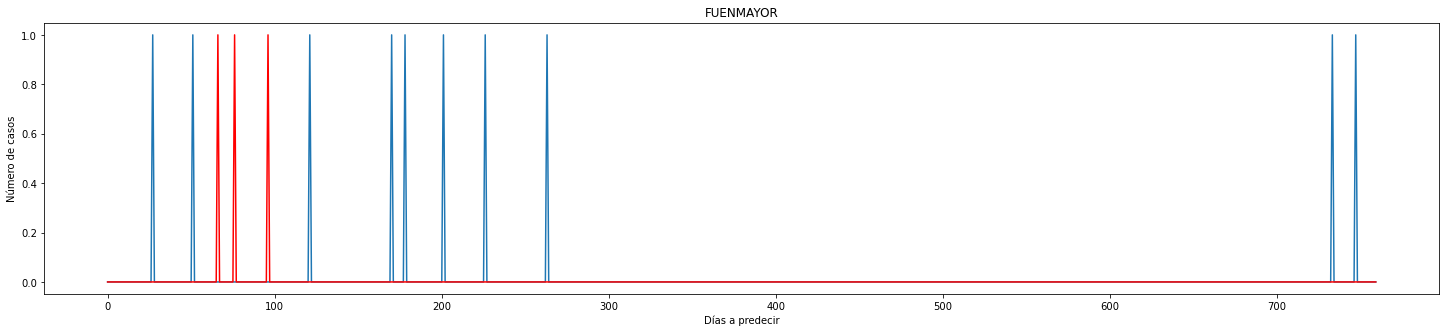

Test RMSE: 0.135 - Total predictions: 3 - Real cases: 11 - LAGS: 600 - Days to predict: 770


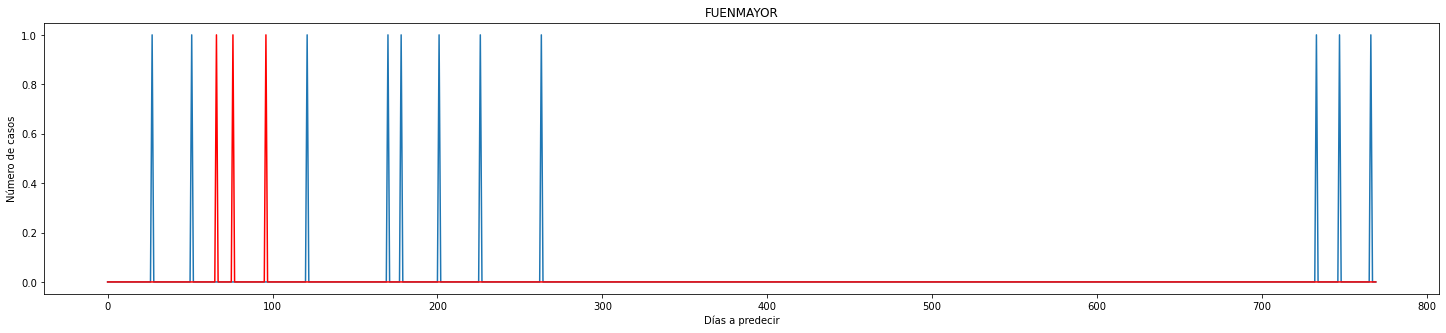

Test RMSE: 0.134 - Total predictions: 3 - Real cases: 11 - LAGS: 600 - Days to predict: 780


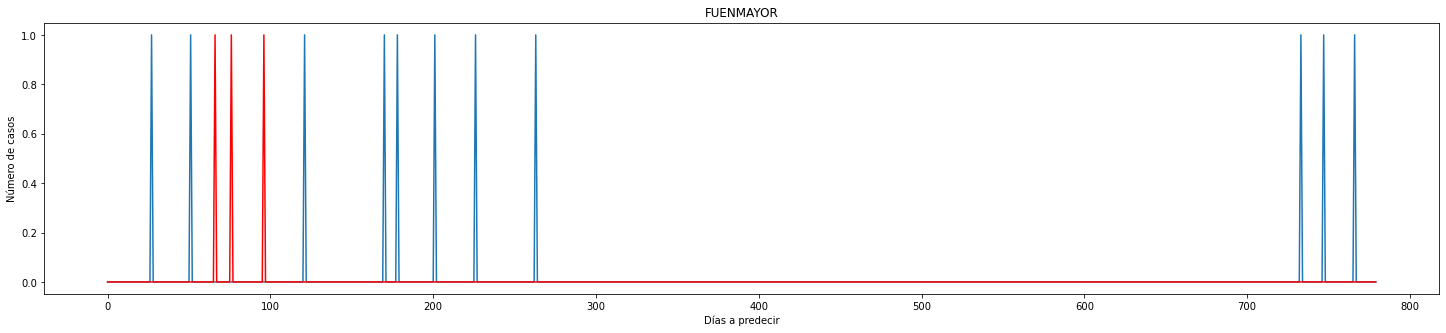

Test RMSE: 0.133 - Total predictions: 3 - Real cases: 11 - LAGS: 600 - Days to predict: 790


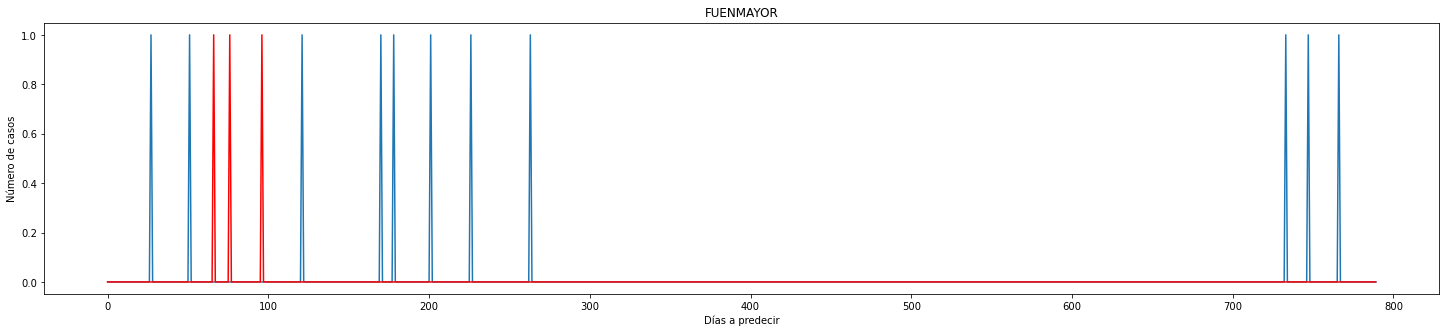

Test RMSE: 0.137 - Total predictions: 3 - Real cases: 12 - LAGS: 600 - Days to predict: 800


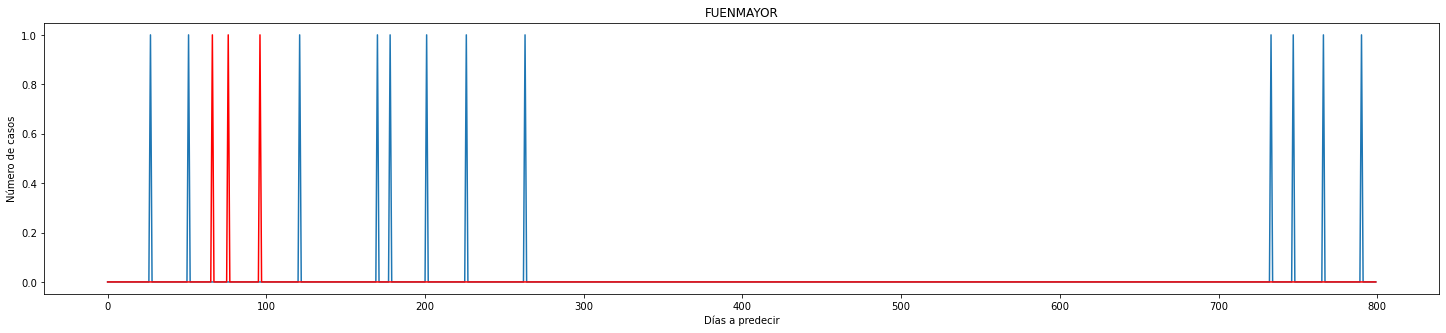

Test RMSE: 0.136 - Total predictions: 3 - Real cases: 12 - LAGS: 600 - Days to predict: 810


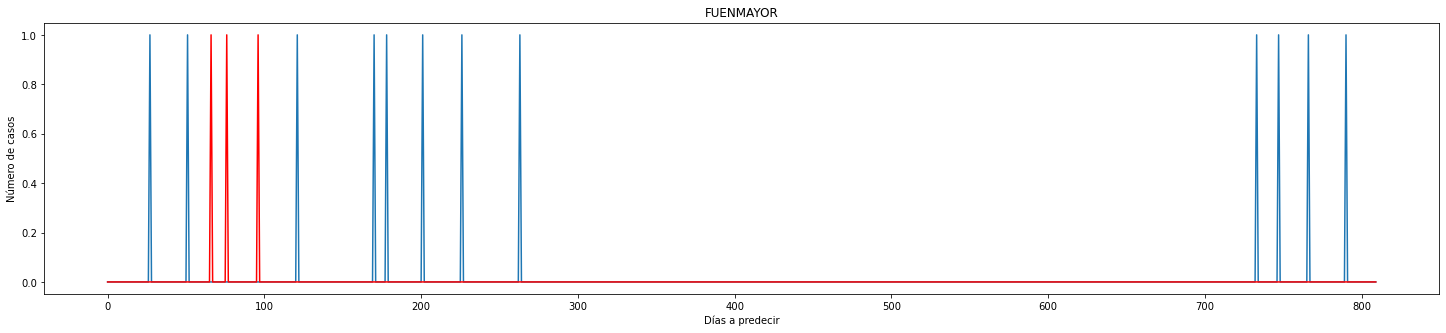

Test RMSE: 0.135 - Total predictions: 3 - Real cases: 12 - LAGS: 600 - Days to predict: 820


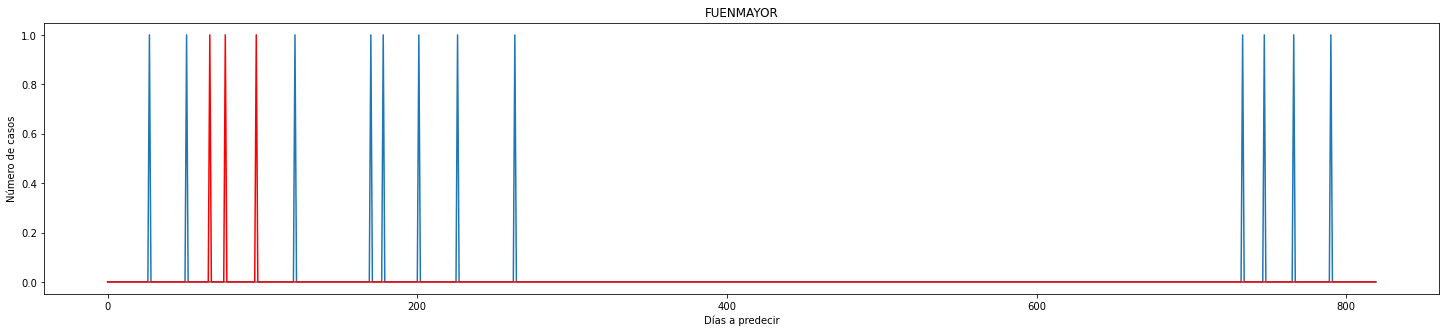

Test RMSE: 0.143 - Total predictions: 3 - Real cases: 14 - LAGS: 600 - Days to predict: 830


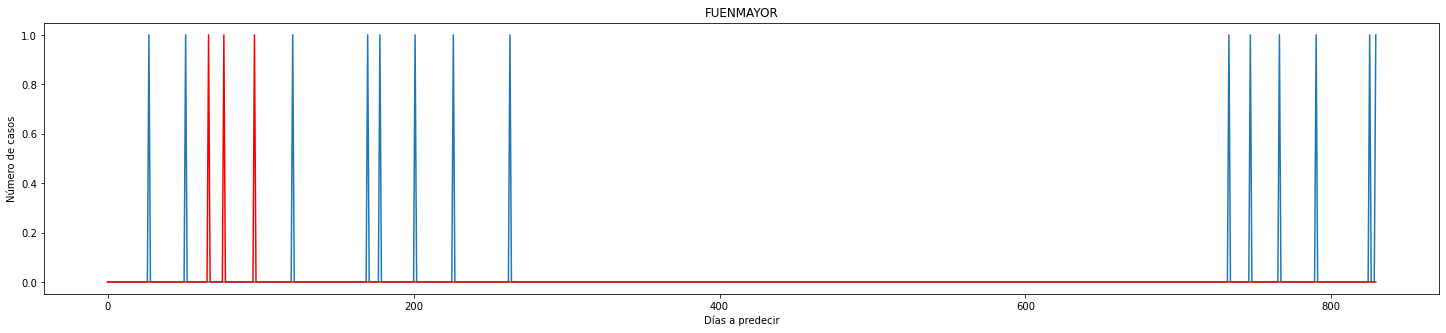

Test RMSE: 0.150 - Total predictions: 3 - Real cases: 16 - LAGS: 600 - Days to predict: 840


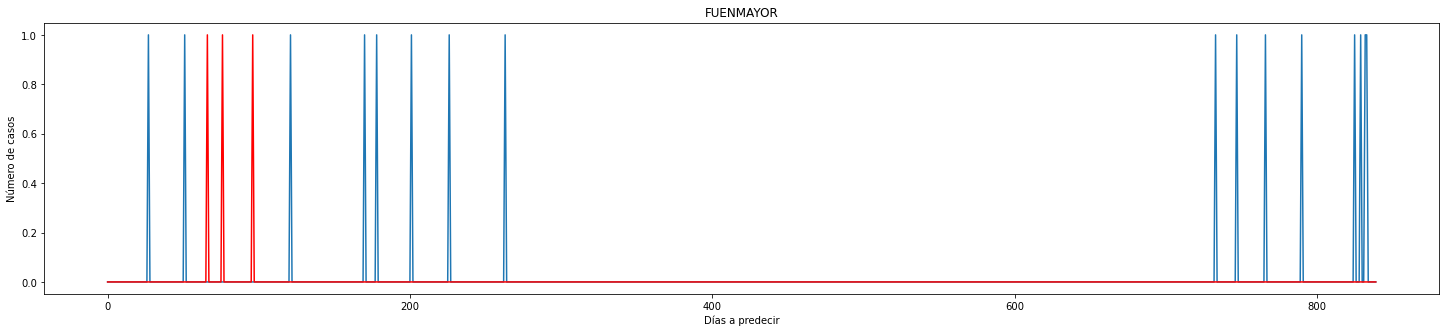

Test RMSE: 0.150 - Total predictions: 3 - Real cases: 16 - LAGS: 600 - Days to predict: 850


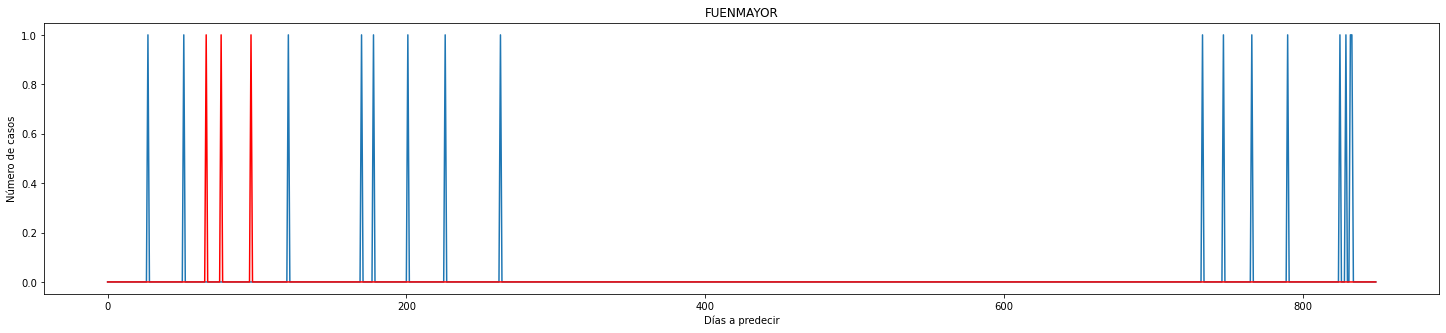

Test RMSE: 0.152 - Total predictions: 3 - Real cases: 17 - LAGS: 600 - Days to predict: 860


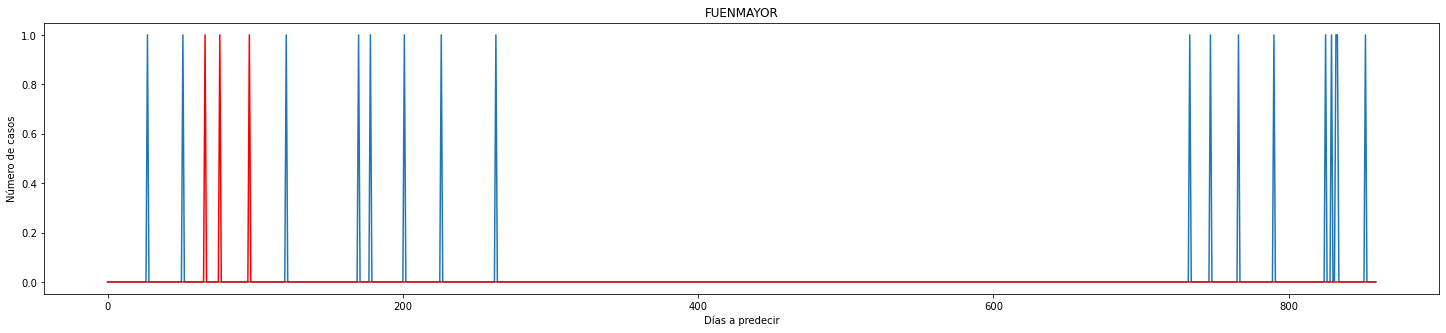

Test RMSE: 0.155 - Total predictions: 3 - Real cases: 18 - LAGS: 600 - Days to predict: 870


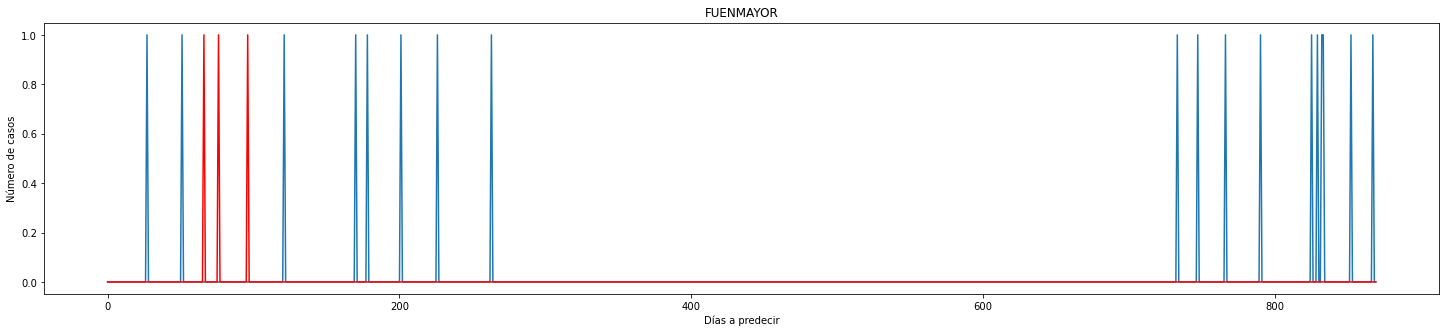

Test RMSE: 0.154 - Total predictions: 3 - Real cases: 18 - LAGS: 600 - Days to predict: 880


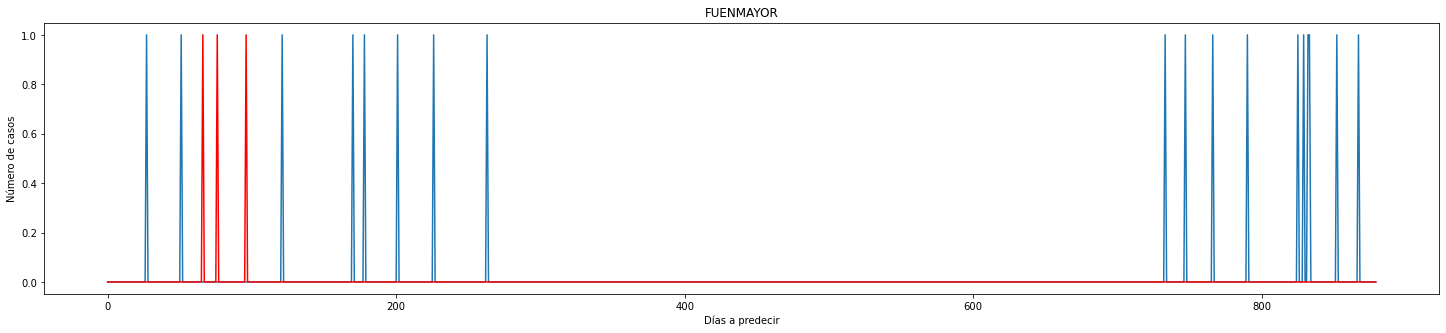

Test RMSE: 0.154 - Total predictions: 3 - Real cases: 18 - LAGS: 600 - Days to predict: 890


KeyboardInterrupt: 

In [213]:
evaluate_model(neighborhoods, 'Buga')

### GIRÓN

In [10]:
dfGiron = df[df.City == 'Girón']

Test RMSE: 0.074


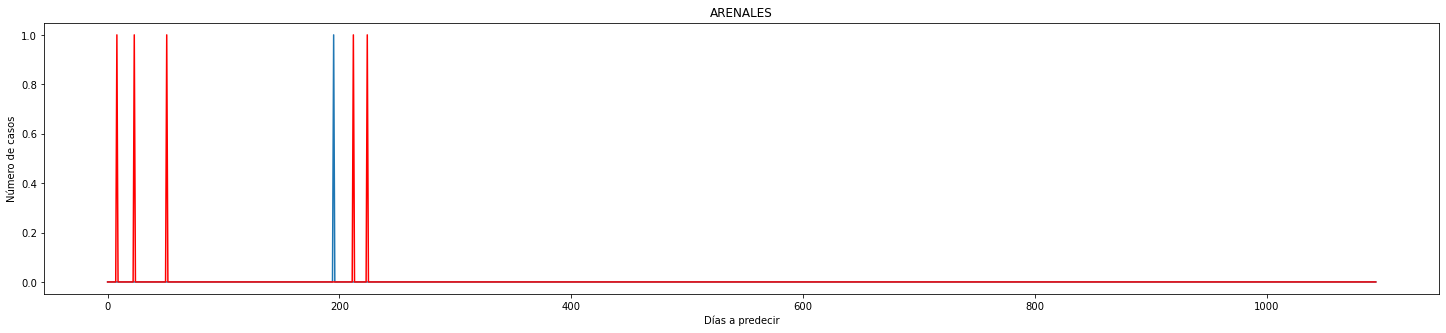

Test RMSE: 0.218


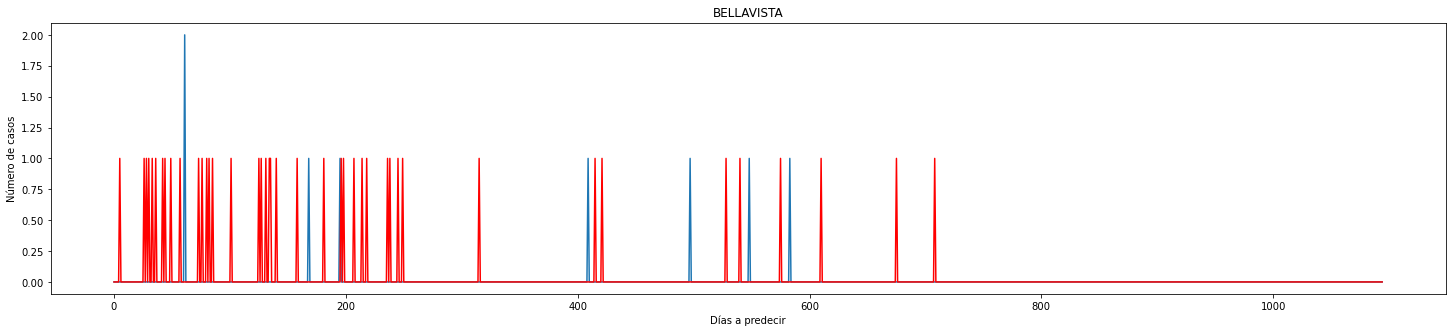

Test RMSE: 0.324


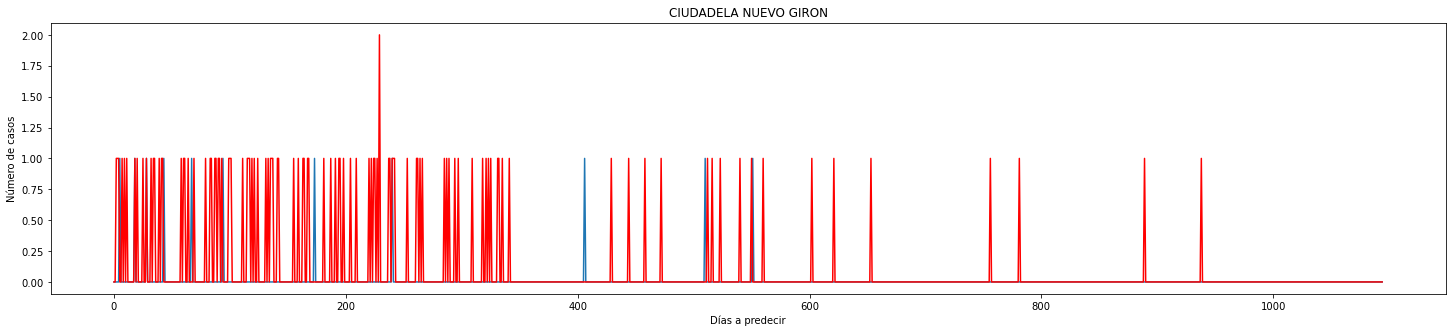

Test RMSE: 0.091


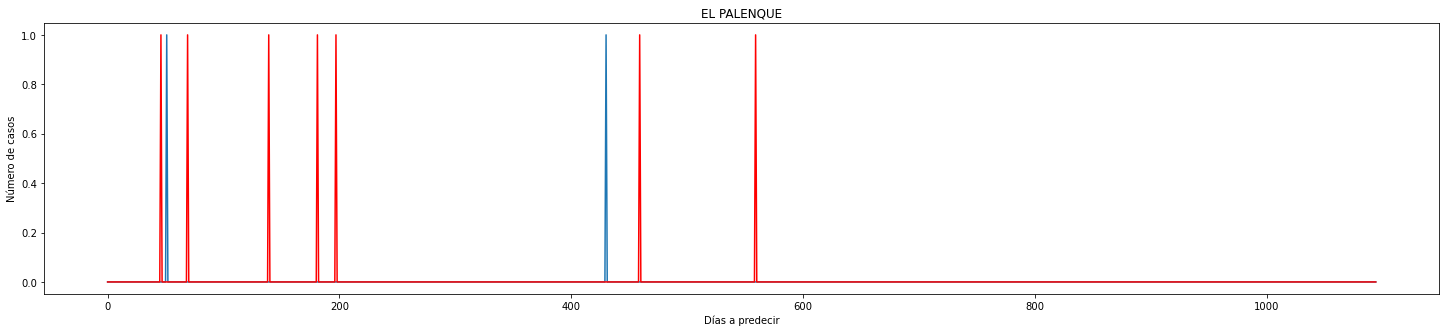

Test RMSE: 0.341


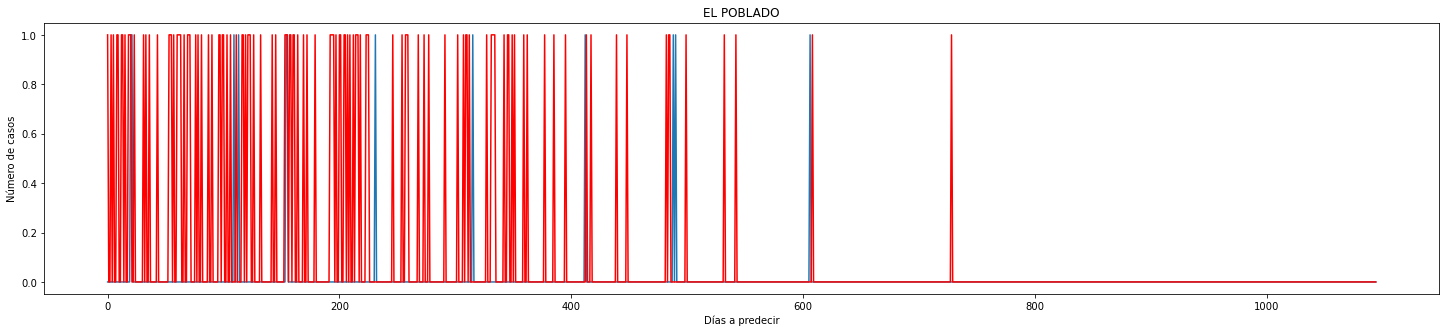

Test RMSE: 0.145


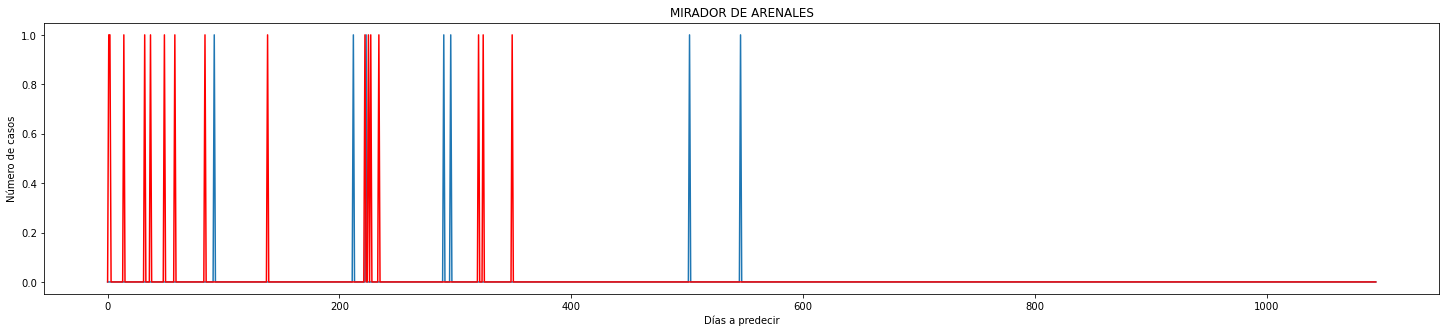

Test RMSE: 0.226


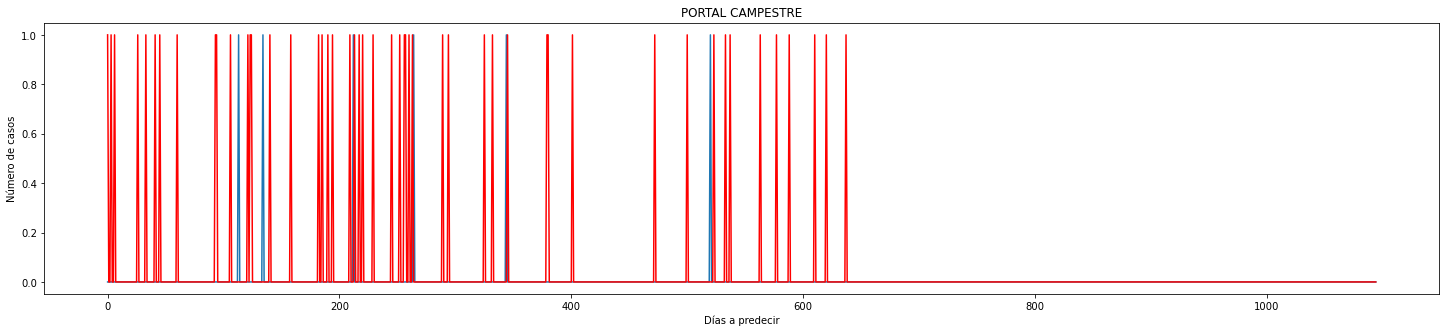

Test RMSE: 0.472


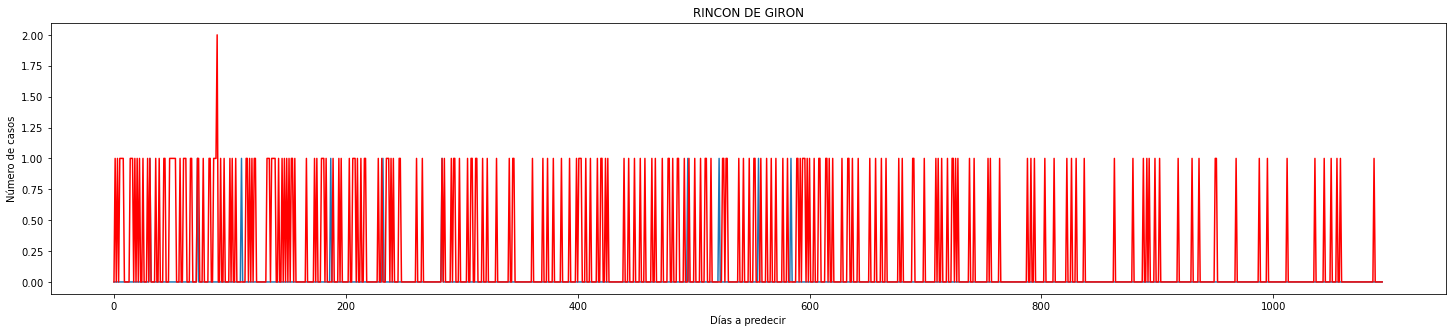

Test RMSE: 0.191


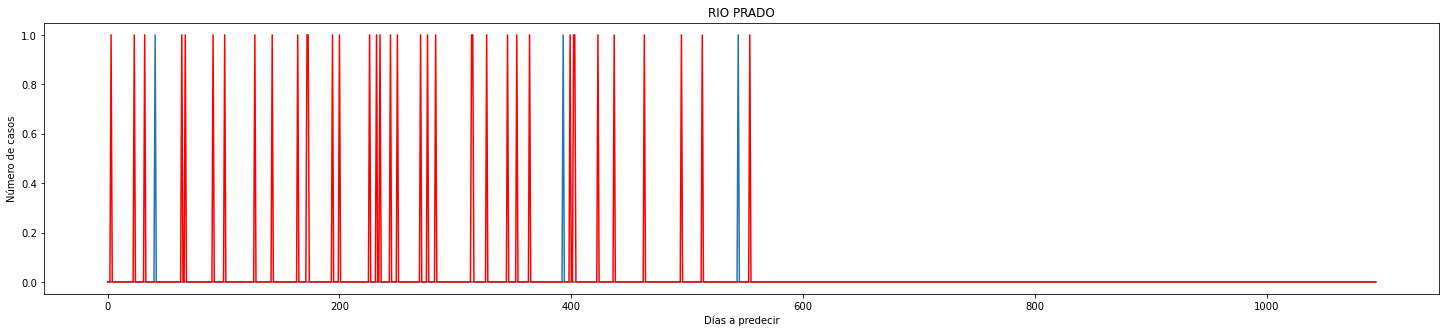

Test RMSE: 0.184


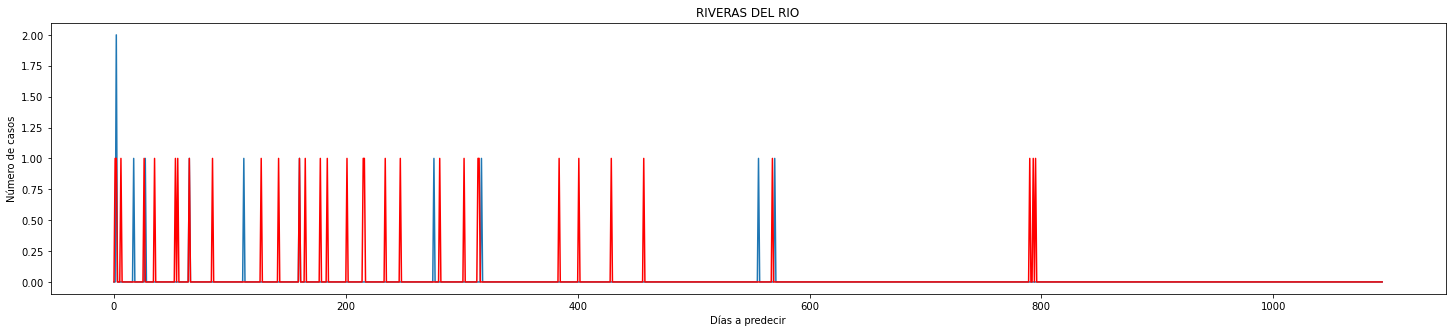

Test RMSE: 0.207


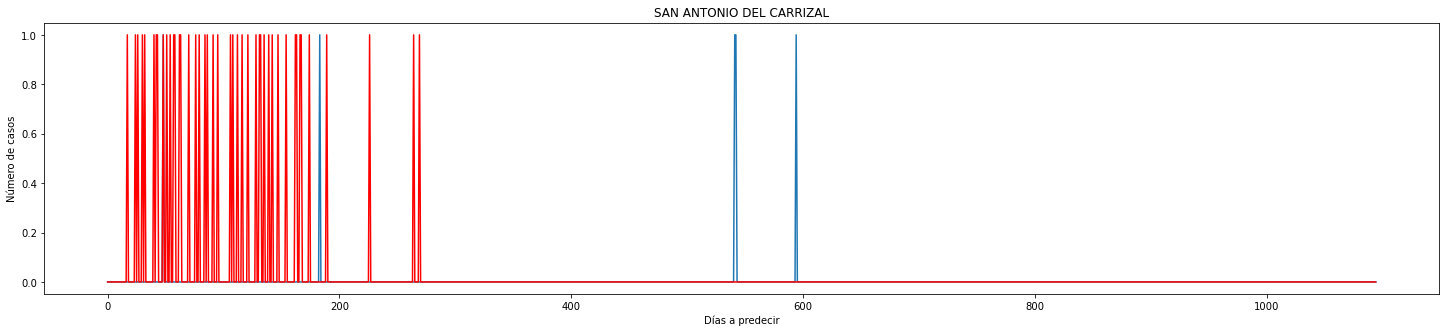

Test RMSE: 0.232


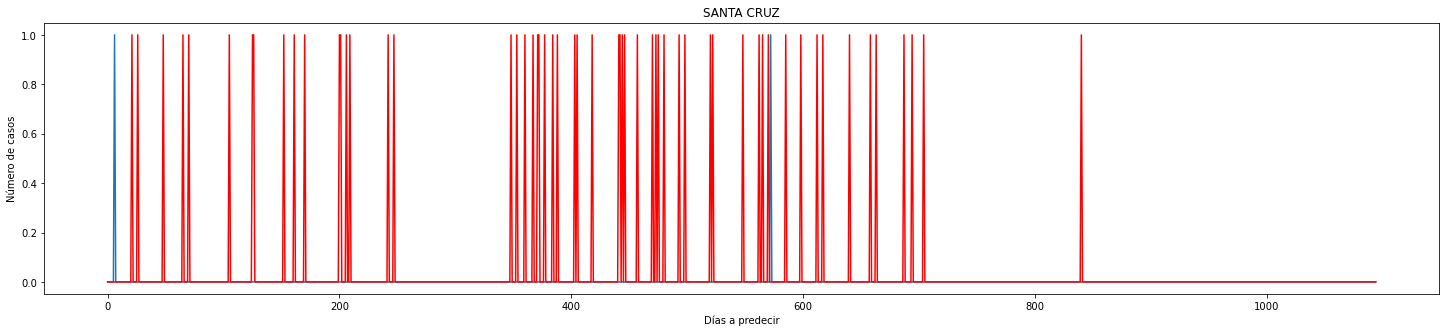

Test RMSE: 0.085


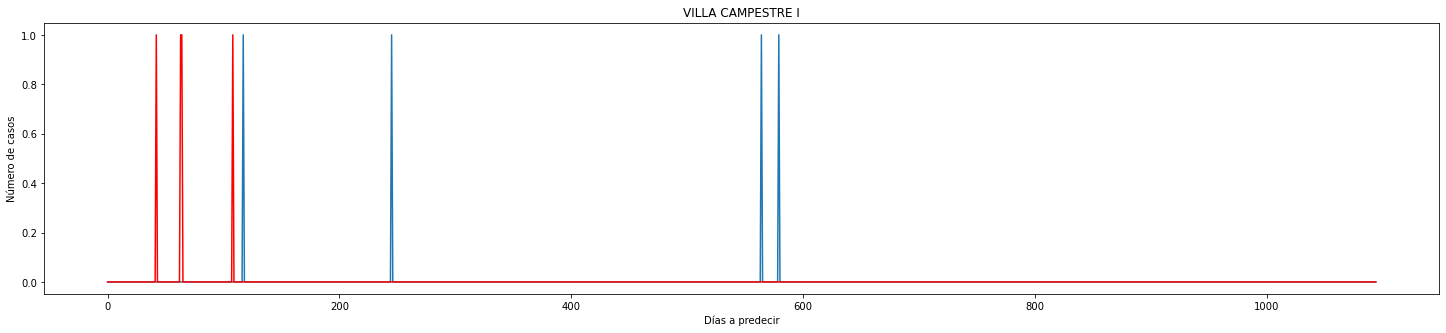

Test RMSE: 0.189


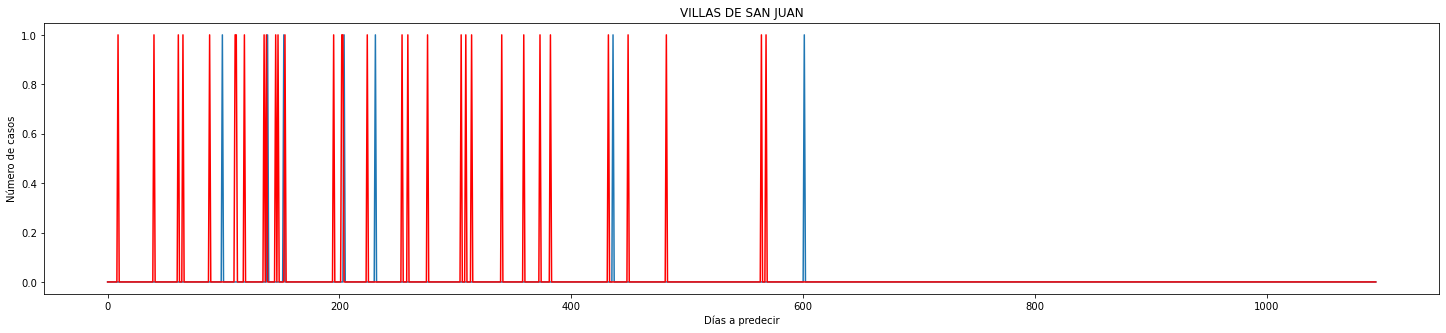

In [11]:
neighborhoods_df = dfGiron['Neighborhood'].value_counts().sort_index()
runModel(neighborhoods_df, 'Giron')

### YOPAL

In [1]:
dfYopal = df[df.City == 'Yopal']

NameError: name 'df' is not defined

In [ ]:
neighborhoods_df = dfYopal['Neighborhood'].value_counts().sort_index()
runModel(neighborhoods_df, 'Yopal')